# DATA601

Joshua Black

## Exploring 'philoso*' subset with text analytics

The philosophy subset is the collection of all documents in the corpus containing matches with the regex pattern 'philoso*'. 

This document will use concordancing, collocation, and cooccurance to develop a sense of how the word 'philosophy' appears in the corpus and to pick out other related terms which may be useful for picking out philosophical writing from the corpus.

In [2]:
#Imports
from __future__ import print_function

import sys
import os
import glob
import re
import logging
from random import sample

import pandas as pd
import numpy as np
import networkx as nx

from gensim import corpora
from gensim.models import LdaMulticore, TfidfModel
from gensim.matutils import corpus2csc

from nltk.text import Text
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import stopwords, words

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

import NL_helpers
import NL_topicmodels # Will need to generate BOW using function in topic models.

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

TOKENIZER = RegexpTokenizer(r"[A-Za-z']+")
STOPWORDS = set(stopwords.words())
WORDS = set(words.words())

In [3]:
# Run cell to reload NL_helpers and NL_topicmodels if they have been changed.
from importlib import reload
reload(NL_helpers)
reload(NL_topicmodels)

<module 'NL_topicmodels' from '/home/joshua/hdd/Documents/MADS/DATA601/NL_topicmodels.py'>

### Loading Dataset

I have already generated a dataset containing all articles with the regex search term 'philoso*' run on the NL library. I load it as follows:

**Note, error:** the step at which I apply the search is before the text has been converted to lower case. The results of the re search are case sensitive. I had intended to include, e.g. 'Philosophy' as well. I don't expect that this will cause too many problems. 

In [7]:
philoso_df = pd.read_pickle('pickles/philoso_df.tar.gz')

In [5]:
philoso_df['Tokenised'] = philoso_df['Text'].map(
    lambda x: TOKENIZER.tokenize(NL_helpers.blocks2string(x).lower())
)

In [7]:
# Duplicates ought to be removed from 'subset' corpus, but have already been removed from full 'philoso*' corpus.
# philoso_df = philoso_df[~philoso_df.astype(str).duplicated()]

In [8]:
# Counts by newspaper
philoso_df.index.map(lambda x: x[0:x.find('_')]).value_counts()

OW         273
ODT        257
LT         203
AS         199
CHP        184
ESD        180
NZTIM      139
DSC        124
NOT        103
TC         100
BH          99
HBH         76
DTN         66
NEM         63
WSTAR       62
OAM         59
MEX         56
WCT         50
WH          50
WT          42
WDT         40
CROMARG     37
WC          36
CL          36
WI          35
MIC         35
LWM         31
GLOBE       31
GRA         30
DUNST       25
AG          24
ME          23
GBARG       20
HNS         17
NZSCSG      16
WOODEX      15
WAIST       14
IT          14
BA          13
HBT         13
WEST        11
FS          10
KUMAT        8
LCP          8
MT           6
OO           5
HAST         5
MH           4
NZCPNA       3
NZGWS        3
HBWT         3
NA           3
OG           2
MS           2
OPUNT        1
dtype: int64

The above output shows that we have 29575 items containing 'philoso\*' in the whole dataset. This is between two and three times the size of the 'starter corpus', but is significantly smaller than the total corpus. **TODO: put full size here.**

I've also produced a count for each newspaper. OW - the Otago Witness tops the list. Surprising as this was a weekly paper and so should be expected to have less total issues than the others. However, it might have had more 'intellectual' content 

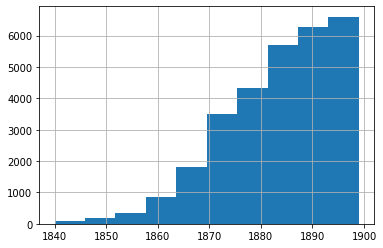

In [6]:
# Counts by year.
philoso_df.index.map(lambda x: int(x[x.find('_')+1:x.find('_')+5])).to_series().hist()

### Basic Exploration

#### Inspecting a subset of the corpus

We can look at a random subset of the corpus as follows:

In [15]:
sample_indices = sample(list(philoso_df.index), 100)
interact(NL_helpers.html_text, index=sample_indices, dataframe=fixed(philoso_df), boldface=fixed('philoso*\\w*'))

2020-12-31 13:53:14,302 : INFO : Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-31 13:53:14,303 : INFO : NumExpr defaulting to 8 threads.


interactive(children=(Dropdown(description='index', options=('NZTIM_18960222_ARTICLE45', 'GLOBE_18810303_ARTIC…

<function NL_helpers.html_text(index, dataframe, boldface=None)>

A few notes: * (Note your random sample will be different)
 - AS_18860821_ARTICLE40: Example of argument with 'freethinker' over grouding ethics(?) in 'natural right' vs Christian approach. Interesting as lower limit in terms of OCR quality?
 - Use of 'philosophical' to mean deep, resigned, detatched.
 - 'philosophers and sceptics' vs Christians.
 - CHP_18980425_ARTICLE60: Report of what is issued at the wellington public library in 1898 - 'philosophical subjects are almost entire;y neglected'
 - Discussion of Darwinism as new philosophy.
 - Discussions of e.g. Stoicism.
 - 1893 Hosking on Miricles, listed as 'popular lecture'. CHP_18930515_ARTICLE22
 - **In general, quite a few reprints of exerpts from texts. (e.g. BH_18890222_ARTICLE33)
 - Robert Stout comes up a lot as an early political figure who is thought of as having, e.g. 'a philosophic mind'.
 - Some lecture reports coming through (e.g. AS_18800817_ARTICLE22, CHP_18690823_ARTICLE15)
 - Theosophy coming through
 - Quite a lot of extracts of fiction (one with a Hegelian character).
 - CL_18790919_ARTICLE27 - first-order philosophy - including definition of 'philosophy' in Clutha Leader.
 - CHP_18920926_ARTICLE10 - good letters to editor on 'freethought' and christianity
 

#### Concordancing

We begin by quickly looking through concordances for key words. The initial 'flat list' of tokens is taken from a random sample of 1000 items in the corpus.

In [16]:
flat_list = []
for tokens in philoso_df['Tokenised'].sample(n=1000, random_state=1):
    for token in tokens:
        flat_list.append(token)
sample_text = Text(flat_list)
del flat_list

This notebook keeps the full dataset in memory. I'll be using 'del' to remove references to large objects.

First up, 'philosophy':

In [17]:
sample_text.concordance('philosophy', width=100, lines=150)

Displaying 150 of 423 matches:
 lightly and in her heart of hearts re gards philosophy as a nuisance and mr her bert spencer as an 
eve i shall ' with this marked taste for the philosophy of character and of situation he may during 
sfcijtu e r r r fpunded to inves t' tosjw of philosophy and jlmjmqe in jnpjre especially any al agai
quiries into its origin it needs very little philosophy to understand the causes from whence it has 
 for the nonce the deep 'problems of science philosophy and isw and enter in the passing games or so
bit of an explorer who is tinctured with the philosophy of tom dram believing that the world has a p
ery member of it in the simple but pro found philosophy and also in the snbllmest life of jesus of n
tched superstition opposing their bril diant philosophy one of rome's strongest objections to christ
nd i hato oho replied to bring tho spiritual philosophy to deal with tho inane things of thl earthly
elves to the dangerous charm of specula live philosophy and 

Notable:
 - discussion of 'natural philosophy' and 'experimental philosophy' - what would today be called 'science'.
 - generic use of 'philosophy' as 'way of thinking'
 - philosophy as 'extravagant theories'
 - Quite a few descriptions of people 'aquire his graveful pedantry his philosophy his ripe wisdom' which sound like descriptions in a Victorian novel... There is quite a bit of serialised fiction in the general corpus.
 - some discussion of academic situations (classrooms etc)
  - mention of particular philosophers both ancient and contemp (Plato, the stoics, Descartes, Spencer, Carlyle)
  - Ambiguous relationship with theology. 
  - NZ figures: e.g. Robert Stout

In [18]:
sample_text.concordance('lecture', width=100, lines=150)

Displaying 145 of 145 matches:
ng next when the rev j w stack will deliver a lecture on the maoris of the middle island the incomi
inated a notable incident in his career was a lecture on ' science and religion in which being deli
wn the australian church the deceased judge s lecture consisted for the most part of a eolemio agai
mr charles bright delivered his controversial lecture on ' jesus worship the chair was taken by bob
specially on such a subject as the one of his lecture but it must be remembered that the world adva
o more than the information that an ameri can lecture bureau had cabled to their eng lish agent to 
ture mr charles bright dolivered his farewell lecture ia dunedin on sund j evening last at the prin
nd the theatre was crowded the buhject of the lecture was evolution its processes and possibilities
ended in the unknown at the conclusion of the lecture the chairman baid he was there that evening f
xisted in this community and that mr b ight's lecture had been attend

In [19]:
del sample_text

#### Collocations

Collocations shows which words have a tendency to appear together *near one another* in documents (cf. co-occurrence). The ranking of word pairs depends on the statistic chosen.

**PMI:** pointwise mutual information is a measure from information theory. Suppose we have probability distributions for each word, *x* and *y*, we might wonder how much information about p(x) is carried by p(y). If the words *x* and *y* always occur together, then *pmi* will be very high. This makes PMI a good measure of word occurence (dreadful - come back once you've reminded yourself how this works).

**Likelihood ratio:**

The code below collects all immediate bigrams for a window of size 2 and of size 5. We then filter our bigrams which do not contain 'philosophy', those which appear less than three times, and those which contain stopwords.

We again build up a flat list, but this time with the whole corpus.

In [20]:
flat_list = []
for tokens in philoso_df['Tokenised']:
    for token in tokens:
        flat_list.append(token)
all_text = Text(flat_list)
del flat_list

##### Window size = 2

In [60]:
philoso_filter = lambda *w: 'philosophy' not in w
stopword_filter = lambda w: w in STOPWORDS

In [61]:
bcf = BigramCollocationFinder.from_words(all_text)

In [62]:
bcf.apply_ngram_filter(philoso_filter)
bcf.apply_word_filter(stopword_filter)
bcf.apply_freq_filter(10)

In [63]:
bm = BigramAssocMeasures()

In [64]:
pmi_ws2 = bcf.nbest(bm.pmi, 50)
pmi_ws2

[('synthetic', 'philosophy'),
 ('baconian', 'philosophy'),
 ('proverbial', 'philosophy'),
 ('epicurean', 'philosophy'),
 ('cosmic', 'philosophy'),
 ('inductive', 'philosophy'),
 ('transcendental', 'philosophy'),
 ('stoic', 'philosophy'),
 ('pessimistic', 'philosophy'),
 ('platonic', 'philosophy'),
 ('experimental', 'philosophy'),
 ("spencer's", 'philosophy'),
 ('speculative', 'philosophy'),
 ('materialistic', 'philosophy'),
 ('natural', 'philosophy'),
 ('utilitarian', 'philosophy'),
 ('truest', 'philosophy'),
 ('ethical', 'philosophy'),
 ('sceptical', 'philosophy'),
 ('philosophy', 'chemistry'),
 ('mental', 'philosophy'),
 ('philosophy', 'teaches'),
 ('false', 'philosophy'),
 ('pig', 'philosophy'),
 ('quaint', 'philosophy'),
 ('cheerful', 'philosophy'),
 ('positive', 'philosophy'),
 ('abstract', 'philosophy'),
 ('greek', 'philosophy'),
 ('mechanical', 'philosophy'),
 ('profound', 'philosophy'),
 ('studied', 'philosophy'),
 ('theology', 'philosophy'),
 ('sound', 'philosophy'),
 ('philos

With a window size of two, we get words either side of 'philosophy'.
Notes:
 - natural comes up again, along with 'experimental', 'positive', 'inductive'. 
 - 'pig philosophy' is, I think, a term of Carylye's - suggest some specific discussions.
 - most suggest intellectual discussion (except maybe 'proverbial'.

In [65]:
lr_ws2 = bcf.nbest(bm.likelihood_ratio, 50)
lr_ws2

[('natural', 'philosophy'),
 ('proverbial', 'philosophy'),
 ('mental', 'philosophy'),
 ('political', 'philosophy'),
 ('true', 'philosophy'),
 ('science', 'philosophy'),
 ('sound', 'philosophy'),
 ('false', 'philosophy'),
 ('speculative', 'philosophy'),
 ('experimental', 'philosophy'),
 ('modern', 'philosophy'),
 ('philosophy', 'chemistry'),
 ('greek', 'philosophy'),
 ('social', 'philosophy'),
 ('inductive', 'philosophy'),
 ('synthetic', 'philosophy'),
 ('practical', 'philosophy'),
 ('baconian', 'philosophy'),
 ('literature', 'philosophy'),
 ('divine', 'philosophy'),
 ('stoic', 'philosophy'),
 ('philosophy', 'science'),
 ('spiritual', 'philosophy'),
 ('history', 'philosophy'),
 ('whole', 'philosophy'),
 ('poetry', 'philosophy'),
 ('materialistic', 'philosophy'),
 ('epicurean', 'philosophy'),
 ('philosophy', 'class'),
 ('positive', 'philosophy'),
 ('profound', 'philosophy'),
 ('cosmic', 'philosophy'),
 ('cheerful', 'philosophy'),
 ('studied', 'philosophy'),
 ('teach', 'philosophy'),
 ('a

In [66]:
pmi_not_lr = []
for collocation in pmi_ws2:
    if collocation not in lr_ws2:
        pmi_not_lr.append(collocation)
pmi_not_lr

[('platonic', 'philosophy'),
 ('philosophy', 'teaches'),
 ('quaint', 'philosophy'),
 ('abstract', 'philosophy'),
 ('mechanical', 'philosophy'),
 ('philosophy', 'prior'),
 ('eastern', 'philosophy'),
 ('philosophy', 'logic')]

In [67]:
lr_not_pmi = []
for collocation in lr_ws2:
    if collocation not in pmi_ws2:
        lr_not_pmi.append(collocation)
lr_not_pmi

[('philosophy', 'science'),
 ('history', 'philosophy'),
 ('whole', 'philosophy'),
 ('philosophy', 'class'),
 ('ancient', 'philosophy'),
 ('philosophy', 'physical'),
 ('german', 'philosophy'),
 ('christian', 'philosophy')]

The differences here don't seem to make a big difference to the conclusions above. Not surprising as they are very closely related measures.

In [22]:
del bcf
del all_text

##### Window size = 5

We can also expand the window to consider words either five spaces to the left or right of philosophy. (Window size includes stopwords)

In [71]:
bcf_big = BigramCollocationFinder.from_words(all_text, window_size=5)

In [72]:
bcf_big.apply_ngram_filter(philoso_filter)
bcf_big.apply_word_filter(stopword_filter)
bcf_big.apply_freq_filter(10)

In [73]:
pmi_ws5 = bcf_big.nbest(bm.pmi, 50)
pmi_ws5

[('philosophy', 'reflectiveness'),
 ('synthetic', 'philosophy'),
 ('dreamt', 'philosophy'),
 ('undreamed', 'philosophy'),
 ('baconian', 'philosophy'),
 ('undreamt', 'philosophy'),
 ('proverbial', 'philosophy'),
 ('epicurean', 'philosophy'),
 ('philosophy', 'apparel'),
 ('axioms', 'philosophy'),
 ('matics', 'philosophy'),
 ('inductive', 'philosophy'),
 ('cosmic', 'philosophy'),
 ('foregoing', 'philosophy'),
 ('transcendental', 'philosophy'),
 ('mathematics', 'philosophy'),
 ('philosophy', 'enslaved'),
 ('stoic', 'philosophy'),
 ('dreamed', 'philosophy'),
 ('experimental', 'philosophy'),
 ("spencer's", 'philosophy'),
 ('rhetoric', 'philosophy'),
 ('pessimistic', 'philosophy'),
 ('philosophy', 'physics'),
 ('esoteric', 'philosophy'),
 ('philosophy', 'mineralogy'),
 ('philology', 'philosophy'),
 ('philosophy', 'chemistry'),
 ('mathe', 'philosophy'),
 ('platonic', 'philosophy'),
 ('philosophy', 'jurisprudence'),
 ('geometry', 'philosophy'),
 ('philosophy', 'logy'),
 ('philosophy', 'falsely'

The general impression of these collocations is quite similar to those with window size two. 
Notes:
 - I've noticed 'there are more things in heaven and earth than dreamt ...' a few times while looking through the corpus. I supsect ('dreamt', 'philosophy') comes from this.
 - There's more evidence of 'natural philosophy' etc. We also get 'mental philosophy' something like psychology.
 - Discussion of Herbert Spencer coming through also.
 - In general: evidence of intellectual content.

In [74]:
lr_ws5 = bcf_big.nbest(bm.likelihood_ratio, 50)
lr_ws5

[('natural', 'philosophy'),
 ('dreamt', 'philosophy'),
 ('science', 'philosophy'),
 ('mental', 'philosophy'),
 ('literature', 'philosophy'),
 ('mathematics', 'philosophy'),
 ('philosophy', 'science'),
 ('history', 'philosophy'),
 ('philosophy', 'economy'),
 ('proverbial', 'philosophy'),
 ('philosophy', 'chemistry'),
 ('philosophy', 'theology'),
 ('poetry', 'philosophy'),
 ('philosophy', 'history'),
 ('chair', 'philosophy'),
 ('political', 'philosophy'),
 ('art', 'philosophy'),
 ('philosophy', 'political'),
 ('philosophy', 'religion'),
 ('study', 'philosophy'),
 ('dreamed', 'philosophy'),
 ('foregoing', 'philosophy'),
 ('professor', 'philosophy'),
 ('theology', 'philosophy'),
 ('logic', 'philosophy'),
 ('modern', 'philosophy'),
 ('true', 'philosophy'),
 ('philosophy', 'apparel'),
 ('religion', 'philosophy'),
 ('philosophy', 'clothing'),
 ('false', 'philosophy'),
 ('sound', 'philosophy'),
 ('philosophy', 'dress'),
 ('experimental', 'philosophy'),
 ('philosophy', 'physics'),
 ('philosophy

In [75]:
pmi_not_lr_ws5 = []
for collocation in pmi_ws5:
    if collocation not in lr_ws5:
        pmi_not_lr_ws5.append(collocation)
pmi_not_lr_ws5

[('synthetic', 'philosophy'),
 ('undreamed', 'philosophy'),
 ('baconian', 'philosophy'),
 ('undreamt', 'philosophy'),
 ('epicurean', 'philosophy'),
 ('axioms', 'philosophy'),
 ('matics', 'philosophy'),
 ('inductive', 'philosophy'),
 ('cosmic', 'philosophy'),
 ('transcendental', 'philosophy'),
 ('philosophy', 'enslaved'),
 ('stoic', 'philosophy'),
 ("spencer's", 'philosophy'),
 ('rhetoric', 'philosophy'),
 ('pessimistic', 'philosophy'),
 ('esoteric', 'philosophy'),
 ('philosophy', 'mineralogy'),
 ('philology', 'philosophy'),
 ('mathe', 'philosophy'),
 ('platonic', 'philosophy'),
 ('philosophy', 'jurisprudence'),
 ('geometry', 'philosophy'),
 ('philosophy', 'logy'),
 ('philosophy', 'falsely'),
 ('materialistic', 'philosophy'),
 ('philosophy', 'aristotle'),
 ('utilitarian', 'philosophy'),
 ('treatise', 'philosophy'),
 ('philosophy', 'deceit'),
 ('philosophy', 'graphy'),
 ('algebra', 'philosophy'),
 ('philosophy', 'metaphysics')]

In [76]:
lr_not_pmi_ws5 = []
for collocation in lr_ws5:
    if collocation not in pmi_ws5:
        lr_not_pmi_ws5.append(collocation)
lr_not_pmi_ws5

[('science', 'philosophy'),
 ('literature', 'philosophy'),
 ('philosophy', 'science'),
 ('history', 'philosophy'),
 ('poetry', 'philosophy'),
 ('philosophy', 'history'),
 ('chair', 'philosophy'),
 ('political', 'philosophy'),
 ('art', 'philosophy'),
 ('philosophy', 'political'),
 ('philosophy', 'religion'),
 ('study', 'philosophy'),
 ('professor', 'philosophy'),
 ('theology', 'philosophy'),
 ('modern', 'philosophy'),
 ('true', 'philosophy'),
 ('religion', 'philosophy'),
 ('philosophy', 'clothing'),
 ('false', 'philosophy'),
 ('sound', 'philosophy'),
 ('philosophy', 'dress'),
 ('philosophy', 'logic'),
 ('philosophy', 'art'),
 ('greek', 'philosophy'),
 ('understood', 'philosophy'),
 ('system', 'philosophy'),
 ('philosophy', 'poetry'),
 ('chemistry', 'philosophy'),
 ('systems', 'philosophy'),
 ('teach', 'philosophy'),
 ('economy', 'philosophy'),
 ('philosophy', 'geology')]

More difference in results here (more ngrams to choose between). But neither list gives a particularly different impression of the corpus as a whole.

In [77]:
len(lr_not_pmi_ws5)

32

In [ ]:
del bcf_big, all_text

Differences in scoring more pronounced.

#### Co-occurence

To perform document-level cooccurence analysis we will shift from NLTK to gensim. We first build a dictionary.

In [9]:
minimum_in_docs = 10 # 10
max_prop = 0.5
dictionary = corpora.Dictionary(philoso_df['Proper Nouns'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

2021-01-07 19:04:34,494 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-07 19:04:36,458 : INFO : adding document #10000 to Dictionary(317560 unique tokens: ['ACes ', 'Ac ', 'Britianf ', 'England', 'Europe']...)
2021-01-07 19:04:38,285 : INFO : adding document #20000 to Dictionary(505496 unique tokens: ['ACes ', 'Ac ', 'Britianf ', 'England', 'Europe']...)
2021-01-07 19:04:40,485 : INFO : built Dictionary(712092 unique tokens: ['ACes ', 'Ac ', 'Britianf ', 'England', 'Europe']...) from 29647 documents (total 3395460 corpus positions)
2021-01-07 19:04:41,425 : INFO : discarding 680031 tokens: [('ACes ', 1), ('Britianf ', 1), ('Lothing ', 1), ('Tjunfl ', 1), ('affOrtl ', 1), ('ihg ', 9), ('iorm ', 2), ('lalatable ', 1), ('loverty ', 1), ('mtfl ', 1)]...
2021-01-07 19:04:41,425 : INFO : keeping 32061 tokens which were in no less than 10 and no more than 14823 (=50.0%) documents
2021-01-07 19:04:41,628 : INFO : resulting dictionary: Dictionary(32061 unique tokens: ['A

In [10]:
dictionary.save(f'dictionaries/philoso_df_min{minimum_in_docs}_max{int(max_prop*100)}perc.dict')

2021-01-07 17:17:29,173 : INFO : saving Dictionary object under dictionaries/philoso_df_min10_max50perc_filtered.dict, separately None
2021-01-07 17:17:29,188 : INFO : saved dictionaries/philoso_df_min10_max50perc_filtered.dict


This dictionary is much too large for our purposes (at ~70k words). We can filter stop words and all one and two letter words from the tokenized text to see what happens.

In [8]:
philoso_df['Tokenised'] = philoso_df['Tokenised'].map(lambda x: [word for word in x if len(word)>2 and not word in STOPWORDS and word in WORDS])

In [78]:
minimum_in_docs = 60 # 10
max_prop = 0.5
dictionary = corpora.Dictionary(philoso_df['Tokenised'])
dictionary.filter_extremes(no_below=minimum_in_docs, no_above=max_prop)
dictionary.compactify()

2020-12-31 14:59:21,868 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-12-31 14:59:27,505 : INFO : adding document #10000 to Dictionary(38355 unique tokens: ['able', 'achieve', 'advantage', 'aggression', 'aggressive']...)
2020-12-31 14:59:32,557 : INFO : adding document #20000 to Dictionary(43732 unique tokens: ['able', 'achieve', 'advantage', 'aggression', 'aggressive']...)
2020-12-31 14:59:38,542 : INFO : built Dictionary(47788 unique tokens: ['able', 'achieve', 'advantage', 'aggression', 'aggressive']...) from 29647 documents (total 15611378 corpus positions)
2020-12-31 14:59:38,610 : INFO : discarding 34289 tokens: [('good', 18437), ('great', 20047), ('heaper', 1), ('industrialism', 10), ('lood', 26), ('may', 20424), ('militarism', 24), ('much', 18759), ('must', 16288), ('present', 14878)]...
2020-12-31 14:59:38,611 : INFO : keeping 13499 tokens which were in no less than 60 and no more than 14823 (=50.0%) documents
2020-12-31 14:59:38,632 : INFO : resulting di

In [11]:
philo_corpus = NL_topicmodels.NL_corpus(philoso_df, dictionary)

In [12]:
tfidf_model = TfidfModel(philo_corpus, dictionary=philo_corpus.dictionary)

2021-01-07 17:17:52,836 : WARNING : constructor received both corpus and explicit inverse document frequencies; ignoring the corpus


In [13]:
philo_corpus.items

,Title,Text,Newspaper,Date,Tokenised,BOW
NA_18870416_ARTICLE4,FOEEIGN AGGRESSION.,"[Fob some time past the colonial defences, the...",NaN,NaN,"[fob, time, past, colonial, position, successf...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
NA_18870813_ARTICLE27,WHANGAREI MUTUAL IMPROVEMENT ASSOCIATION.,"[On Friday evening the debate "" Moral Suasion""...",NaN,NaN,"[evening, debate, suasion, versus, corporal, p...","[(48, 1), (68, 1), (80, 1), (101, 1), (127, 1)..."
NA_18871022_ARTICLE5,The Northern Advocate.,"[OUR COAL FIELDS. y, Ont Thursday last the Hon...",NaN,NaN,"[coal, last, house, annual, report, mines, dep...","[(22, 2), (23, 1), (24, 2), (33, 1), (44, 1), ..."
NA_18880204_ARTICLE21,HEART WISDON.,[Unnumbered years have sped since first The bu...,NaN,NaN,"[unnumbered, sped, since, first, bud, life, bl...","[(9, 1), (36, 2), (52, 1), (69, 1), (86, 1), (..."
NA_18880623_ARTICLE29,OUR AUCKLAND LETTER. I,"[« (From our own Correspondent.) Auckland, Tue...",NaN,NaN,"[correspondent, death, emperor, german, empero...","[(22, 1), (25, 1), (66, 1), (70, 3), (80, 1), ..."
...,...,...,...,...,...,...
ODT_18980917_ARTICLE15,BOOK NOTICES.,"["" Corleone."" By F. Marion Crawford. London: M...",ODT,18980917,"[colonial, library, may, among, contemporary, ...","[(6, 2), (9, 1), (25, 1), (35, 1), (49, 2), (5..."
ODT_18980924_ARTICLE5,PASSING- NOTES.,"[It is difficult to believe, probably nobody, ...",ODT,18980924,"[difficult, believe, probably, nobody, believe...","[(13, 1), (18, 1), (22, 1), (23, 1), (29, 1), ..."
ODT_18981008_ARTICLE15,PUBLISHED BY SPECIAL ARRANGEMENT. WILD EELLIN ...,"[COPYRIGHT., CHAPTER XXXIIL—""SEI MIR GEG-, RUE...",ODT,18981008,"[copyright, chapter, lily, along, shell, garde...","[(6, 3), (9, 3), (17, 1), (18, 2), (20, 1), (2..."
ODT_18981013_ARTICLE51,BISMARCK.,"[THE ATTEMPT OP AN ESTIMATE, ,■'•,' (By O. E. ...",ODT,18981013,"[attempt, estimate, weakness, force, world, ki...","[(0, 1), (6, 1), (10, 1), (22, 1), (35, 1), (6..."


In [14]:
philo_corpus.items['TF-IDF'] = tfidf_model[philo_corpus]

In [318]:
philo_corpus.items

,Newspaper,Date,Title,Text,Tokenised,BOW,TF-IDF
AG_18791028_ARTICLE16,AG,18791028,Aerial Navigation.,[The problem of aerial navigation has taken th...,"[the, problem, of, aerial, navigation, has, ta...","[(1, 1), (94, 2), (101, 1), (111, 1), (131, 2)...","[(1, 0.0424565072112209), (94, 0.0644046124864..."
AG_18791104_ARTICLE22,AG,18791104,How we Catch Cold.,[This pertinent question is just now en gaging...,"[this, pertinent, question, is, just, now, en,...","[(20, 1), (27, 1), (76, 2), (124, 1), (143, 1)...","[(20, 0.030342815927283943), (27, 0.0450904025..."
AG_18791113_ARTICLE31,AG,18791113,The Great London.,"[(From Ike. Spectator),, London, said Lord Car...","[from, ike, spectator, london, said, lord, car...","[(12, 1), (22, 1), (25, 1), (28, 1), (34, 1), ...","[(12, 0.023278623477486743), (22, 0.1039078309..."
AG_18791118_ARTICLE1,AG,18791118,"The Ashburton Guardian, COUNTY AGRICULTURAL & ...",[The Cattle Show is one of the most deservedly...,"[the, cattle, show, is, one, of, the, most, de...","[(0, 1), (5, 2), (76, 1), (78, 1), (98, 1), (1...","[(0, 0.016814618313667304), (5, 0.029803369683..."
AG_18800224_ARTICLE5,AG,18800224,UNTITLED,[Mount Somers Assessment Court.— The Mount Som...,"[mount, somers, assessment, court, the, mount,...","[(0, 1), (5, 1), (8, 1), (12, 2), (33, 1), (34...","[(0, 0.009438412390780351), (5, 0.008364641065..."
...,...,...,...,...,...,...,...
NA_18990722_ARTICLE11,NA,18990722,"The Northern Advocate. ""Sworn to no master, o...",[. : —•- '■ Progressive We to-day a Liberalism...,"[', progressive, we, to, day, a, liberalism, m...","[(0, 1), (4, 2), (9, 1), (14, 1), (34, 2), (41...","[(0, 0.014341969779810199), (4, 0.059750333385..."
NA_18990819_ARTICLE43,NA,18990819,New Zealand Notes.,[Mr Seddon -says New Zealand is committed to t...,"[mr, seddon, says, new, zealand, is, committed...","[(5, 1), (15, 1), (17, 1), (19, 1), (20, 1), (...","[(5, 0.01711343978612903), (15, 0.044038874860..."
NA_18990902_ARTICLE3,NA,18990902,HER REFEREE.,[The manager threw the manuscript down upon th...,"[the, manager, threw, the, manuscript, down, u...","[(5, 1), (20, 1), (32, 1), (77, 1), (89, 1), (...","[(5, 0.011138982573704192), (20, 0.01664818659..."
NA_18991014_ARTICLE14,NA,18991014,"The Northern Advocate. "" Sworn to no master o...","[A Political • In ' our advertising Aspirant, ...","[a, political, in, ', our, advertising, aspira...","[(0, 1), (33, 1), (43, 1), (106, 1), (110, 1),...","[(0, 0.023834952866753033), (33, 0.02359858292..."


Changes over time? - I don't think this is helping me. Need some more non-philosophy as a background.

In [15]:
sparse = corpus2csc(philo_corpus.items['TF-IDF'])

In [16]:
dtm = pd.DataFrame.sparse.from_spmatrix(sparse)
del sparse

In [17]:
dtm.index = philo_corpus.dictionary.values()

In [18]:
dtm

,0,1,2,3,4,5,6,7,8,9,...,29637,29638,29639,29640,29641,29642,29643,29644,29645,29646
able,0.021535,0.0,0.0,0.0,0.0,0.009922,0.013532,0.0,0.0,0.006754,...,0.0,0.0,0.009778,0.0,0.0,0.0,0.0,0.0,0.024968,0.0
achieve,0.088488,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
advantage,0.044849,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
aggression,0.116143,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
aggressive,0.102823,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
junketing,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
filleul,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
classroom,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
lorgnette,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [19]:
dtm.to_pickle('pickles/dtm_TF-IDF_25kwords.tar.gz')

In [324]:
binary_dtm = dtm_filtered.clip(lower=0,upper=1)

In [171]:
binary_dtm

,0,1,2,3,4,5,6,7,8,9,...,5465,5466,5467,5468,5469,5470,5471,5472,5473,5474
able,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
ac,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aces,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
achieve,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
advantage,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
heathcote,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
virdow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
leithfield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
tt_df = binary_dtm.dot(binary_dtm.transpose())

NameError: name 'binary_dtm' is not defined

In [20]:
tt_df = dtm.dot(dtm.transpose())

In [22]:
tt_df.to_pickle('pickles/tt_TF-IDF_25kwords.tar.gz')

In [21]:
tt_df

,able,achieve,advantage,aggression,aggressive,ambition,among,anil,anomalous,ask,...,pash,howsoever,analogue,jotter,unawed,junketing,filleul,classroom,lorgnette,pasquin
able,4.689435,0.164817,0.898947,0.071040,0.096182,0.340012,1.486757,0.290436,0.073133,0.994962,...,0.005253,0.006320,0.001945,0.004971,0.011161,0.008931,0.013631,0.006586,0.006478,0.008924
achieve,0.164817,1.574847,0.135295,0.015810,0.029418,0.067442,0.179269,0.039905,0.012026,0.086507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
advantage,0.898947,0.135295,3.772012,0.026876,0.046046,0.159507,0.809537,0.163598,0.047254,0.511045,...,0.002298,0.005687,0.001739,0.000913,0.003240,0.004457,0.015073,0.003529,0.004475,0.006714
aggression,0.071040,0.015810,0.026876,0.756259,0.047378,0.039714,0.084674,0.016519,0.013200,0.045326,...,0.000000,0.000000,0.000000,0.008376,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
aggressive,0.096182,0.029418,0.046046,0.047378,1.129786,0.028466,0.114184,0.042753,0.018216,0.081107,...,0.000000,0.000000,0.000000,0.000000,0.002135,0.000000,0.000000,0.001247,0.002993,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
junketing,0.008931,0.000000,0.004457,0.000000,0.000000,0.000000,0.014790,0.000000,0.000000,0.001187,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.113147,0.000000,0.000000,0.000000,0.000000
filleul,0.013631,0.000000,0.015073,0.000000,0.000000,0.001719,0.010171,0.000000,0.002060,0.001355,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140676,0.000000,0.000000,0.000000
classroom,0.006586,0.000000,0.003529,0.000000,0.001247,0.000000,0.011677,0.003599,0.000000,0.001827,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087038,0.000000,0.000000
lorgnette,0.006478,0.000000,0.004475,0.000000,0.002993,0.000000,0.007709,0.000000,0.000000,0.007600,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.115018,0.000000


In [222]:
# See https://tm4ss.github.io/docs/Tutorial_5_Co-occurrence.html
def dice_coocs(term, dtm, ttm, num_coocs):
    """Return num_coocs with dice statistics given search term
    document-term matrix and term-term matrix. Return as 
    pandas series with terms as indices and significances as values..
    ttm and dtm are pandas dataframes."""
    #num_documents = len(dtm.columns)
    all_term_occurrences = dtm.sum(axis=1)
    term_occurrences = all_term_occurrences[term]
    cooccurrences = ttm.loc[term]
    dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)
    dicesig = dicesig.sort_values(ascending=False)[0:num_coocs]
    return dicesig

In [216]:
dicesig = 2 * cooccurrences / (term_occurrences + all_term_occurrences)

In [189]:
type(dicesig)

pandas.core.series.Series

In [218]:
dicesig.sort_values(ascending=False)[0:15]

theosophy       1.000000
theosophists    0.294118
psychical       0.232558
hindu           0.222222
glorified       0.210526
thibet          0.195122
esoteric        0.190476
bla             0.176471
besant          0.163265
buddhism        0.163265
underlies       0.157895
adepts          0.157895
theosophical    0.157895
occult          0.151515
propaganda      0.146341
dtype: float64

In [39]:
dice_coocs('philosophy', binary_dtm, tt_df, 20)

NameError: name 'dice_coocs' is not defined

In [40]:
NL_helpers.log_dice_coocs('infinite', dtm, tt_df, 20)

/home/joshua/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


infinite     -2.345068
definition   -3.522898
evolution    -3.635328
god          -3.742166
universe     -3.934641
spiritual    -4.045707
sublime      -4.059012
eternal      -4.080863
peasant      -4.163573
revelation   -4.222771
supreme      -4.260047
giant        -4.277585
brow         -4.293587
hence        -4.311122
reverence    -4.322410
sheep        -4.327069
eternity     -4.332313
boiling      -4.359012
divine       -4.392590
hardy        -4.396841
dtype: float64

In [422]:
philo_cooc = dice_coocs('philosophy', binary_dtm, tt_df, 10)

In [423]:
philo_network = NL_helpers.network_dataframe(
    term='philosophy', 
    stat='ml', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=10
)

In [424]:
philo_network_df = pd.DataFrame(data=philo_network)

In [ ]:
network = {}
for item in philo_cooc.iteritems():
    from_list = network.get('source', [])
    from_list.append('philosophy')
    network['source'] = from_list
    to_list = network.get('target', [])
    to_list.append(item[0])
    network['target'] = to_list
    weight_list = network.get('weight', [])
    weight_list.append(item[1])
    network['weight'] = weight_list
    
    item_coocs = dice_coocs(item[0], binary_dtm, tt_df, 10)
    for sub_item in item_coocs.iteritems():
        if item[0] != sub_item[0]:
            from_list = network.get('source', [])
            from_list.append(item[0])
            network['source'] = from_list
            to_list = network.get('target', [])
            to_list.append(sub_item[0])
            network['target'] = to_list
            weight_list = network.get('weight', [])
            weight_list.append(sub_item[1])
            network['weight'] = weight_list
    

In [247]:
network_df = pd.DataFrame(data=network)

In [340]:
network_df

,source,target,weight
0,philosophy,philosophy,1.000000
1,philosophy,life,0.471264
2,philosophy,years,0.448415
3,philosophy,work,0.447386
4,philosophy,make,0.446822
...,...,...,...
95,us,make,0.612493
96,us,never,0.607143
97,us,life,0.607117
98,us,people,0.606792


In [404]:
G = nx.convert_matrix.from_pandas_edgelist(philo_network_df, edge_attr='weight')

In [405]:
edges = G.edges()
weights = [np.exp(G[u][v]['weight']) * 0.01 for u,v in edges]

In [406]:
d = nx.degree(G)
sizes = [(d[node]+1) * 100 for node in G.nodes()]

In [484]:
layout = nx.drawing.layout.spring_layout(G, k=1/np.sqrt(len(G.nodes)))

In [277]:
len(G.nodes)

34

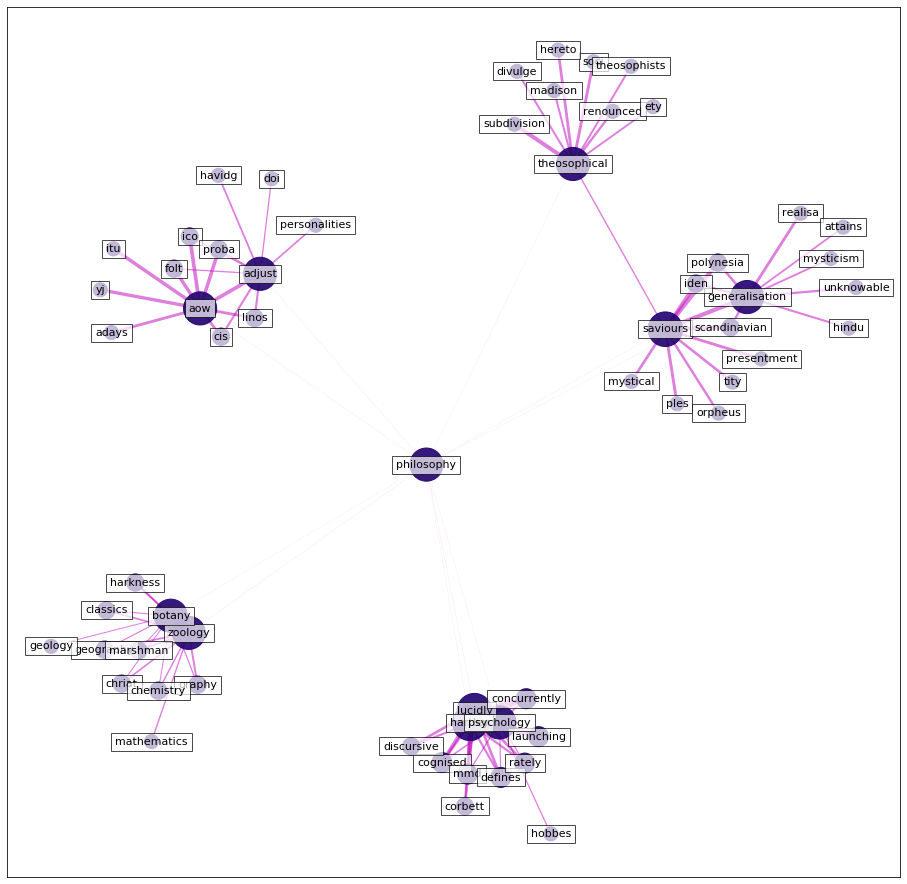

In [485]:
fig, ax = plt.subplots(figsize=(16, 16))
# Visualize graph components
nx.draw_networkx_edges(G, layout, alpha=0.5, width=weights, edge_color="m")
nx.draw_networkx_nodes(G, layout, node_size=sizes, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
labels = nx.draw_networkx_labels(G, layout, font_size=11, bbox=label_options)

In [129]:
philo_net = NL_helpers.network_dash(
    term='philosophy', 
    stat='log dice', 
    dtm=dtm,
    ttm=tt_df,
    num_coocs=25,
    sec_coocs=5
)

/home/joshua/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [532]:
philo_net

[{'data': {'id': 'specialists', 'label': 'specialists', 'size': 7}},
 {'data': {'id': 'rote', 'label': 'rote', 'size': 1}},
 {'data': {'id': 'juliet', 'label': 'juliet', 'size': 1}},
 {'data': {'id': 'speckled', 'label': 'speckled', 'size': 1}},
 {'data': {'id': 'infection', 'label': 'infection', 'size': 1}},
 {'data': {'id': 'slab', 'label': 'slab', 'size': 1}},
 {'data': {'id': 'giveu', 'label': 'giveu', 'size': 19}},
 {'data': {'id': 'laconic', 'label': 'laconic', 'size': 1}},
 {'data': {'id': 'convulsion', 'label': 'convulsion', 'size': 1}},
 {'data': {'id': 'denton', 'label': 'denton', 'size': 1}},
 {'data': {'id': "jew's", 'label': "jew's", 'size': 1}},
 {'data': {'id': 'garrett', 'label': 'garrett', 'size': 1}},
 {'data': {'id': 'undeveloped', 'label': 'undeveloped', 'size': 3}},
 {'data': {'id': 'oho', 'label': 'oho', 'size': 1}},
 {'data': {'id': 'barbarian', 'label': 'barbarian', 'size': 20}},
 {'data': {'id': 'filing', 'label': 'filing', 'size': 19}},
 {'data': {'id': 'amput

In [130]:
app = JupyterDash(__name__)

philo_cytoscape = cyto.Cytoscape(
        id='philosophy-network',
        minZoom=1,
        layout={'name': 'cose'},
        style={'width': '100%', 'height': '800px'},
        elements=philo_net,
        stylesheet=[
            {
                'selector': 'edge',
                'style': {
                    'width': 'mapData(weight, 3, 6, 1, 3)',
                    'line-color': 'silver'
                }
            },
            {
                'selector': 'node',
                'style': {
                    'content': 'data(label)',
                    'width': 'mapData(size, 1, 10, 10, 20)',
                    'height': 'mapData(size, 1, 10, 10, 20)'
                }
            },
            {
                'selector': 'label',
                'style': {
                    'font-size': 6,
                    'text-valign': 'center',
                    'text-background-color': 'white',
                    'text-background-opacity': 0.6,
                    'text-background-padding': 1,
                    'text-border-color': 'black',
                    'text-border-opacity': 1,
                    'text-border-width': 0.5
                }
            }
        ]
    )

app.layout = html.Div([
    html.H2("Cooccurence Networks (BOW)"),
    html.P("Search Term:"),
    dcc.Input(
        id='search-term',
        type='text',
        value='philosophy'
    ),
    html.P("Statistic:"),
    dcc.Dropdown(
        id='stat-choice',
        options=[
            {'label': 'Mutual likelihood', 'value': 'ml'},
            {'label': 'Log Dice', 'value': 'log dice'}
        ],
        value='ml'
    ),
    html.Button('Submit', id='submit-val', n_clicks=0),
    philo_cytoscape
])

@app.callback(
    Output(component_id='philosophy-network', component_property='elements'),
    Input(component_id='submit-val', component_property='n_clicks'),
    State(component_id='stat-choice', component_property='value'),
    State(component_id='search-term', component_property='value'),
)
def update_network_stat(n_clicks, stat_value, search_value):
    network = NL_helpers.network_dash(
        term=search_value, 
        stat=stat_value, 
        dtm=dtm,
        ttm=tt_df,
        num_coocs=10,
        sec_coocs=5
    )
    return network 

if __name__ == '__main__':
    app.run_server(debug=True, mode='inline')

#### Word Embeddings

### Next steps

#### Some candidate keywords

In [120]:
NL_helpers.interactive_text_search(philoso_df, "[Mm]ill\'s")

Article matches: 104


interactive(children=(Dropdown(description='index', options=('TC_18620422_ARTICLE13', 'TC_18670730_ARTICLE12',…

In [539]:
NL_helpers.interactive_text_search(philoso_df, '[Hh]artley')

Article matches: 16


interactive(children=(Dropdown(description='index', options=('AS_18760209_ARTICLE14', 'AS_18770317_ARTICLE1', …

#### Expansion of Philosophy Dataset

#### Proposed Classification Scheme

## Bonus: the topic model code again

A convenient moment for running a topic model on the philosophy corpus came up. Here is a model using the full philosophy set dictionary.

In [29]:
len(philoso_df)

29575

In [ ]:
starter_model = LdaMulticore(
    philo_corpus,
    num_topics= 200,
    workers = 15,
    chunksize = 220,
    id2word=philo_corpus.dictionary,
    iterations = 500,
    passes = 25,
    eval_every = 100
)

2020-12-24 13:57:15,928 : INFO : using symmetric alpha at 0.005
2020-12-24 13:57:15,931 : INFO : using symmetric eta at 0.005
2020-12-24 13:57:16,055 : INFO : using serial LDA version on this node
2020-12-24 13:57:18,060 : INFO : running online LDA training, 200 topics, 25 passes over the supplied corpus of 29575 documents, updating every 3300 documents, evaluating every ~29575 documents, iterating 500x with a convergence threshold of 0.001000
2020-12-24 13:57:18,062 : INFO : training LDA model using 15 processes
2020-12-24 13:57:24,270 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #220/29575, outstanding queue size 1
2020-12-24 13:57:24,579 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #440/29575, outstanding queue size 2
2020-12-24 13:57:24,581 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #660/29575, outstanding queue size 3
2020-12-24 13:57:24,583 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #880/29575, ou

2020-12-24 13:57:42,245 : INFO : topic #145 (0.005): 0.006*"tho" + 0.005*"she" + 0.004*"d" + 0.003*"ab" + 0.003*"m" + 0.003*"mrs" + 0.003*"auckland" + 0.003*"work" + 0.003*"college" + 0.002*"her"
2020-12-24 13:57:42,246 : INFO : topic #148 (0.005): 0.007*"you" + 0.005*"m" + 0.005*"f" + 0.004*"r" + 0.004*"w" + 0.003*"v" + 0.003*"d" + 0.003*"tho" + 0.003*"tbe" + 0.003*"your"
2020-12-24 13:57:42,248 : INFO : topic #181 (0.005): 0.006*"you" + 0.003*"her" + 0.003*"your" + 0.002*"d" + 0.002*"work" + 0.002*"thing" + 0.002*"per" + 0.002*"c" + 0.002*"th" + 0.002*"life"
2020-12-24 13:57:42,250 : INFO : topic #15 (0.005): 0.016*"you" + 0.008*"her" + 0.006*"she" + 0.004*"my" + 0.004*"your" + 0.003*"tho" + 0.003*"young" + 0.003*"know" + 0.003*"bowling" + 0.003*"me"
2020-12-24 13:57:42,283 : INFO : topic diff=180.371323, rho=1.000000
2020-12-24 13:57:42,308 : INFO : PROGRESS: pass 0, dispatched chunk #58 = documents up to #12980/29575, outstanding queue size 39
2020-12-24 13:57:53,493 : INFO : mergi

2020-12-24 13:58:05,976 : INFO : topic #92 (0.005): 0.004*"bhe" + 0.004*"my" + 0.002*"life" + 0.002*"her" + 0.002*"me" + 0.002*"you" + 0.002*"also" + 0.002*"young" + 0.002*"education" + 0.002*"ib"
2020-12-24 13:58:05,978 : INFO : topic #47 (0.005): 0.004*"you" + 0.003*"my" + 0.002*"m" + 0.002*"given" + 0.002*"house" + 0.002*"same" + 0.002*"take" + 0.002*"where" + 0.002*"government" + 0.002*"th"
2020-12-24 13:58:05,991 : INFO : topic diff=0.243842, rho=0.137361
2020-12-24 13:58:06,009 : INFO : PROGRESS: pass 0, dispatched chunk #101 = documents up to #22440/29575, outstanding queue size 24
2020-12-24 13:58:07,244 : INFO : PROGRESS: pass 0, dispatched chunk #102 = documents up to #22660/29575, outstanding queue size 20
2020-12-24 13:58:07,365 : INFO : PROGRESS: pass 0, dispatched chunk #103 = documents up to #22880/29575, outstanding queue size 21
2020-12-24 13:58:07,366 : INFO : PROGRESS: pass 0, dispatched chunk #104 = documents up to #23100/29575, outstanding queue size 22
2020-12-24 

2020-12-24 13:58:27,590 : INFO : topic diff=0.197470, rho=0.095346
2020-12-24 13:58:29,277 : INFO : -10.736 per-word bound, 1705.1 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 13:58:30,835 : INFO : merging changes from 2075 documents into a model of 29575 documents
2020-12-24 13:58:31,300 : INFO : topic #122 (0.005): 0.006*"her" + 0.005*"f" + 0.005*"l" + 0.004*"m" + 0.004*"e" + 0.004*"w" + 0.004*"r" + 0.003*"n" + 0.003*"she" + 0.003*"o"
2020-12-24 13:58:31,302 : INFO : topic #42 (0.005): 0.006*"you" + 0.003*"rev" + 0.003*"church" + 0.003*"did" + 0.003*"my" + 0.003*"m" + 0.002*"tho" + 0.002*"work" + 0.002*"place" + 0.002*"dr"
2020-12-24 13:58:31,304 : INFO : topic #170 (0.005): 0.016*"you" + 0.011*"her" + 0.010*"me" + 0.008*"my" + 0.007*"ye" + 0.007*"she" + 0.005*"your" + 0.003*"o" + 0.003*"am" + 0.002*"see"
2020-12-24 13:58:31,305 : INFO : topic #30 (0.005): 0.005*"tho" + 0.003*"while" + 0.002*"natives" + 0.002*"night" + 0.002*"number" + 0.

2020-12-24 13:58:43,294 : INFO : topic #52 (0.005): 0.030*"she" + 0.029*"her" + 0.022*"you" + 0.007*"me" + 0.005*"tho" + 0.005*"my" + 0.004*"know" + 0.004*"woman" + 0.004*"never" + 0.004*"your"
2020-12-24 13:58:43,295 : INFO : topic #36 (0.005): 0.004*"m" + 0.003*"r" + 0.003*"b" + 0.002*"th" + 0.002*"meeting" + 0.002*"f" + 0.002*"place" + 0.002*"l" + 0.002*"government" + 0.002*"e"
2020-12-24 13:58:43,297 : INFO : topic #45 (0.005): 0.007*"m" + 0.005*"tho" + 0.004*"her" + 0.003*"you" + 0.003*"she" + 0.002*"w" + 0.002*"church" + 0.002*"d" + 0.002*"c" + 0.002*"p"
2020-12-24 13:58:43,316 : INFO : topic diff=0.208738, rho=0.085613
2020-12-24 13:58:43,337 : INFO : PROGRESS: pass 1, dispatched chunk #49 = documents up to #11000/29575, outstanding queue size 30
2020-12-24 13:58:44,405 : INFO : PROGRESS: pass 1, dispatched chunk #50 = documents up to #11220/29575, outstanding queue size 27
2020-12-24 13:58:44,407 : INFO : PROGRESS: pass 1, dispatched chunk #51 = documents up to #11440/29575, ou

2020-12-24 13:59:01,856 : INFO : topic #198 (0.005): 0.008*"my" + 0.007*"you" + 0.005*"know" + 0.005*"spirits" + 0.005*"pain" + 0.005*"body" + 0.004*"syrup" + 0.004*"water" + 0.004*"indigestion" + 0.004*"her"
2020-12-24 13:59:01,858 : INFO : topic #87 (0.005): 0.007*"my" + 0.005*"you" + 0.004*"tho" + 0.003*"me" + 0.003*"life" + 0.002*"your" + 0.002*"might" + 0.002*"never" + 0.002*"without" + 0.002*"matter"
2020-12-24 13:59:01,860 : INFO : topic #172 (0.005): 0.012*"you" + 0.011*"she" + 0.008*"her" + 0.005*"never" + 0.004*"your" + 0.003*"my" + 0.003*"lady" + 0.003*"me" + 0.003*"always" + 0.003*"life"
2020-12-24 13:59:01,861 : INFO : topic #113 (0.005): 0.010*"you" + 0.008*"my" + 0.006*"tho" + 0.006*"ib" + 0.005*"me" + 0.005*"nob" + 0.005*"her" + 0.005*"thab" + 0.004*"she" + 0.004*"bo"
2020-12-24 13:59:01,876 : INFO : topic diff=0.203929, rho=0.085613
2020-12-24 13:59:01,891 : INFO : PROGRESS: pass 1, dispatched chunk #97 = documents up to #21560/29575, outstanding queue size 38
2020-12-

2020-12-24 13:59:25,825 : INFO : PROGRESS: pass 1, dispatched chunk #126 = documents up to #27940/29575, outstanding queue size 6
2020-12-24 13:59:25,826 : INFO : PROGRESS: pass 1, dispatched chunk #127 = documents up to #28160/29575, outstanding queue size 7
2020-12-24 13:59:25,826 : INFO : PROGRESS: pass 1, dispatched chunk #128 = documents up to #28380/29575, outstanding queue size 8
2020-12-24 13:59:25,827 : INFO : PROGRESS: pass 1, dispatched chunk #129 = documents up to #28600/29575, outstanding queue size 9
2020-12-24 13:59:25,828 : INFO : PROGRESS: pass 1, dispatched chunk #130 = documents up to #28820/29575, outstanding queue size 10
2020-12-24 13:59:25,829 : INFO : PROGRESS: pass 1, dispatched chunk #131 = documents up to #29040/29575, outstanding queue size 11
2020-12-24 13:59:25,829 : INFO : PROGRESS: pass 1, dispatched chunk #132 = documents up to #29260/29575, outstanding queue size 12
2020-12-24 13:59:25,830 : INFO : PROGRESS: pass 1, dispatched chunk #133 = documents up

2020-12-24 13:59:36,589 : INFO : PROGRESS: pass 2, dispatched chunk #35 = documents up to #7920/29575, outstanding queue size 36
2020-12-24 13:59:38,292 : INFO : PROGRESS: pass 2, dispatched chunk #36 = documents up to #8140/29575, outstanding queue size 32
2020-12-24 13:59:38,293 : INFO : PROGRESS: pass 2, dispatched chunk #37 = documents up to #8360/29575, outstanding queue size 33
2020-12-24 13:59:38,294 : INFO : PROGRESS: pass 2, dispatched chunk #38 = documents up to #8580/29575, outstanding queue size 34
2020-12-24 13:59:38,294 : INFO : PROGRESS: pass 2, dispatched chunk #39 = documents up to #8800/29575, outstanding queue size 35
2020-12-24 13:59:38,487 : INFO : PROGRESS: pass 2, dispatched chunk #40 = documents up to #9020/29575, outstanding queue size 36
2020-12-24 13:59:38,964 : INFO : PROGRESS: pass 2, dispatched chunk #41 = documents up to #9240/29575, outstanding queue size 37
2020-12-24 13:59:39,396 : INFO : PROGRESS: pass 2, dispatched chunk #42 = documents up to #9460/2

2020-12-24 13:59:58,013 : INFO : PROGRESS: pass 2, dispatched chunk #80 = documents up to #17820/29575, outstanding queue size 29
2020-12-24 13:59:58,014 : INFO : PROGRESS: pass 2, dispatched chunk #81 = documents up to #18040/29575, outstanding queue size 30
2020-12-24 13:59:58,014 : INFO : PROGRESS: pass 2, dispatched chunk #82 = documents up to #18260/29575, outstanding queue size 31
2020-12-24 13:59:58,015 : INFO : PROGRESS: pass 2, dispatched chunk #83 = documents up to #18480/29575, outstanding queue size 32
2020-12-24 13:59:58,015 : INFO : PROGRESS: pass 2, dispatched chunk #84 = documents up to #18700/29575, outstanding queue size 33
2020-12-24 13:59:58,016 : INFO : PROGRESS: pass 2, dispatched chunk #85 = documents up to #18920/29575, outstanding queue size 34
2020-12-24 13:59:58,016 : INFO : PROGRESS: pass 2, dispatched chunk #86 = documents up to #19140/29575, outstanding queue size 35
2020-12-24 13:59:58,151 : INFO : PROGRESS: pass 2, dispatched chunk #87 = documents up to 

2020-12-24 14:00:16,660 : INFO : topic #182 (0.005): 0.003*"evening" + 0.003*"place" + 0.003*"her" + 0.003*"street" + 0.002*"also" + 0.002*"public" + 0.002*"meeting" + 0.002*"having" + 0.002*"board" + 0.002*"few"
2020-12-24 14:00:16,661 : INFO : topic #199 (0.005): 0.010*"tho" + 0.006*"hair" + 0.004*"bald" + 0.004*"steven" + 0.003*"hand" + 0.003*"known" + 0.003*"c" + 0.003*"clairvoyant" + 0.003*"her" + 0.002*"m"
2020-12-24 14:00:16,663 : INFO : topic #18 (0.005): 0.020*"sir" + 0.010*"government" + 0.008*"party" + 0.007*"question" + 0.007*"vote" + 0.006*"george" + 0.006*"colony" + 0.006*"election" + 0.006*"grey" + 0.006*"stout"
2020-12-24 14:00:16,665 : INFO : topic #42 (0.005): 0.007*"bishop" + 0.005*"rev" + 0.005*"church" + 0.005*"you" + 0.003*"diocese" + 0.003*"did" + 0.003*"dr" + 0.003*"work" + 0.002*"name" + 0.002*"my"
2020-12-24 14:00:16,686 : INFO : topic diff=0.296236, rho=0.085301
2020-12-24 14:00:16,801 : INFO : PROGRESS: pass 2, dispatched chunk #124 = documents up to #27500/

2020-12-24 14:00:35,816 : INFO : PROGRESS: pass 3, dispatched chunk #25 = documents up to #5720/29575, outstanding queue size 26
2020-12-24 14:00:35,817 : INFO : PROGRESS: pass 3, dispatched chunk #26 = documents up to #5940/29575, outstanding queue size 27
2020-12-24 14:00:35,817 : INFO : PROGRESS: pass 3, dispatched chunk #27 = documents up to #6160/29575, outstanding queue size 28
2020-12-24 14:00:35,818 : INFO : PROGRESS: pass 3, dispatched chunk #28 = documents up to #6380/29575, outstanding queue size 29
2020-12-24 14:00:35,818 : INFO : PROGRESS: pass 3, dispatched chunk #29 = documents up to #6600/29575, outstanding queue size 30
2020-12-24 14:00:35,920 : INFO : PROGRESS: pass 3, dispatched chunk #30 = documents up to #6820/29575, outstanding queue size 31
2020-12-24 14:00:36,263 : INFO : PROGRESS: pass 3, dispatched chunk #31 = documents up to #7040/29575, outstanding queue size 32
2020-12-24 14:00:36,566 : INFO : PROGRESS: pass 3, dispatched chunk #32 = documents up to #7260/2

2020-12-24 14:00:57,189 : INFO : topic #160 (0.005): 0.022*"book" + 0.016*"story" + 0.011*"novel" + 0.009*"volume" + 0.007*"author" + 0.007*"fiction" + 0.007*"novels" + 0.006*"stories" + 0.006*"edition" + 0.005*"literary"
2020-12-24 14:00:57,203 : INFO : topic diff=0.344891, rho=0.084993
2020-12-24 14:00:57,219 : INFO : PROGRESS: pass 3, dispatched chunk #73 = documents up to #16280/29575, outstanding queue size 30
2020-12-24 14:01:00,089 : INFO : PROGRESS: pass 3, dispatched chunk #74 = documents up to #16500/29575, outstanding queue size 20
2020-12-24 14:01:00,090 : INFO : PROGRESS: pass 3, dispatched chunk #75 = documents up to #16720/29575, outstanding queue size 21
2020-12-24 14:01:00,090 : INFO : PROGRESS: pass 3, dispatched chunk #76 = documents up to #16940/29575, outstanding queue size 22
2020-12-24 14:01:00,091 : INFO : PROGRESS: pass 3, dispatched chunk #77 = documents up to #17160/29575, outstanding queue size 23
2020-12-24 14:01:00,091 : INFO : PROGRESS: pass 3, dispatched

2020-12-24 14:01:12,481 : INFO : PROGRESS: pass 3, dispatched chunk #116 = documents up to #25740/29575, outstanding queue size 34
2020-12-24 14:01:12,483 : INFO : PROGRESS: pass 3, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 35
2020-12-24 14:01:12,483 : INFO : PROGRESS: pass 3, dispatched chunk #118 = documents up to #26180/29575, outstanding queue size 36
2020-12-24 14:01:12,804 : INFO : PROGRESS: pass 3, dispatched chunk #119 = documents up to #26400/29575, outstanding queue size 36
2020-12-24 14:01:13,017 : INFO : PROGRESS: pass 3, dispatched chunk #120 = documents up to #26620/29575, outstanding queue size 36
2020-12-24 14:01:13,392 : INFO : PROGRESS: pass 3, dispatched chunk #121 = documents up to #26840/29575, outstanding queue size 37
2020-12-24 14:01:14,230 : INFO : PROGRESS: pass 3, dispatched chunk #122 = documents up to #27060/29575, outstanding queue size 36
2020-12-24 14:01:14,231 : INFO : PROGRESS: pass 3, dispatched chunk #123 = document

2020-12-24 14:01:36,892 : INFO : PROGRESS: pass 4, dispatched chunk #5 = documents up to #1320/29575, outstanding queue size 6
2020-12-24 14:01:36,892 : INFO : PROGRESS: pass 4, dispatched chunk #6 = documents up to #1540/29575, outstanding queue size 7
2020-12-24 14:01:36,893 : INFO : PROGRESS: pass 4, dispatched chunk #7 = documents up to #1760/29575, outstanding queue size 8
2020-12-24 14:01:36,894 : INFO : PROGRESS: pass 4, dispatched chunk #8 = documents up to #1980/29575, outstanding queue size 9
2020-12-24 14:01:36,894 : INFO : PROGRESS: pass 4, dispatched chunk #9 = documents up to #2200/29575, outstanding queue size 10
2020-12-24 14:01:36,895 : INFO : PROGRESS: pass 4, dispatched chunk #10 = documents up to #2420/29575, outstanding queue size 11
2020-12-24 14:01:36,896 : INFO : PROGRESS: pass 4, dispatched chunk #11 = documents up to #2640/29575, outstanding queue size 12
2020-12-24 14:01:36,897 : INFO : PROGRESS: pass 4, dispatched chunk #12 = documents up to #2860/29575, out

2020-12-24 14:01:50,030 : INFO : PROGRESS: pass 4, dispatched chunk #60 = documents up to #13420/29575, outstanding queue size 32
2020-12-24 14:01:50,031 : INFO : PROGRESS: pass 4, dispatched chunk #61 = documents up to #13640/29575, outstanding queue size 33
2020-12-24 14:01:50,031 : INFO : PROGRESS: pass 4, dispatched chunk #62 = documents up to #13860/29575, outstanding queue size 34
2020-12-24 14:01:50,032 : INFO : PROGRESS: pass 4, dispatched chunk #63 = documents up to #14080/29575, outstanding queue size 35
2020-12-24 14:01:50,252 : INFO : PROGRESS: pass 4, dispatched chunk #64 = documents up to #14300/29575, outstanding queue size 36
2020-12-24 14:01:50,519 : INFO : PROGRESS: pass 4, dispatched chunk #65 = documents up to #14520/29575, outstanding queue size 37
2020-12-24 14:01:51,007 : INFO : PROGRESS: pass 4, dispatched chunk #66 = documents up to #14740/29575, outstanding queue size 37
2020-12-24 14:01:51,319 : INFO : PROGRESS: pass 4, dispatched chunk #67 = documents up to 

2020-12-24 14:02:10,210 : INFO : PROGRESS: pass 4, dispatched chunk #104 = documents up to #23100/29575, outstanding queue size 27
2020-12-24 14:02:10,210 : INFO : PROGRESS: pass 4, dispatched chunk #105 = documents up to #23320/29575, outstanding queue size 28
2020-12-24 14:02:10,211 : INFO : PROGRESS: pass 4, dispatched chunk #106 = documents up to #23540/29575, outstanding queue size 29
2020-12-24 14:02:10,211 : INFO : PROGRESS: pass 4, dispatched chunk #107 = documents up to #23760/29575, outstanding queue size 30
2020-12-24 14:02:10,212 : INFO : PROGRESS: pass 4, dispatched chunk #108 = documents up to #23980/29575, outstanding queue size 31
2020-12-24 14:02:10,212 : INFO : PROGRESS: pass 4, dispatched chunk #109 = documents up to #24200/29575, outstanding queue size 32
2020-12-24 14:02:10,213 : INFO : PROGRESS: pass 4, dispatched chunk #110 = documents up to #24420/29575, outstanding queue size 33
2020-12-24 14:02:10,214 : INFO : PROGRESS: pass 4, dispatched chunk #111 = document

2020-12-24 14:02:37,226 : INFO : topic #101 (0.005): 0.009*"state" + 0.006*"right" + 0.005*"against" + 0.005*"question" + 0.005*"public" + 0.005*"church" + 0.005*"law" + 0.004*"because" + 0.004*"liberty" + 0.004*"land"
2020-12-24 14:02:37,227 : INFO : topic #126 (0.005): 0.075*"chinese" + 0.013*"china" + 0.012*"chinaman" + 0.010*"chinamen" + 0.006*"version" + 0.005*"pekin" + 0.005*"darrell" + 0.004*"immortality" + 0.004*"atom" + 0.003*"tho"
2020-12-24 14:02:37,228 : INFO : topic #60 (0.005): 0.017*"divorce" + 0.015*"christmas" + 0.013*"marriage" + 0.012*"ladies" + 0.012*"cocoa" + 0.011*"wives" + 0.010*"dress" + 0.009*"lace" + 0.009*"costume" + 0.009*"taylor"
2020-12-24 14:02:37,229 : INFO : topic #12 (0.005): 0.004*"her" + 0.003*"she" + 0.002*"my" + 0.002*"never" + 0.002*"life" + 0.002*"too" + 0.002*"himself" + 0.002*"where" + 0.002*"though" + 0.002*"ever"
2020-12-24 14:02:37,241 : INFO : topic diff=0.490651, rho=0.084687
2020-12-24 14:02:38,463 : INFO : -10.253 per-word bound, 1220.0 

2020-12-24 14:02:49,650 : INFO : PROGRESS: pass 5, dispatched chunk #46 = documents up to #10340/29575, outstanding queue size 23
2020-12-24 14:02:49,652 : INFO : PROGRESS: pass 5, dispatched chunk #47 = documents up to #10560/29575, outstanding queue size 24
2020-12-24 14:02:49,653 : INFO : PROGRESS: pass 5, dispatched chunk #48 = documents up to #10780/29575, outstanding queue size 25
2020-12-24 14:02:49,653 : INFO : PROGRESS: pass 5, dispatched chunk #49 = documents up to #11000/29575, outstanding queue size 26
2020-12-24 14:02:49,654 : INFO : PROGRESS: pass 5, dispatched chunk #50 = documents up to #11220/29575, outstanding queue size 27
2020-12-24 14:02:49,655 : INFO : PROGRESS: pass 5, dispatched chunk #51 = documents up to #11440/29575, outstanding queue size 28
2020-12-24 14:02:49,655 : INFO : PROGRESS: pass 5, dispatched chunk #52 = documents up to #11660/29575, outstanding queue size 29
2020-12-24 14:02:49,656 : INFO : PROGRESS: pass 5, dispatched chunk #53 = documents up to 

2020-12-24 14:03:07,978 : INFO : topic #120 (0.005): 0.042*"protection" + 0.032*"trade" + 0.027*"carlyle" + 0.019*"industries" + 0.017*"free" + 0.016*"labor" + 0.014*"duty" + 0.013*"duties" + 0.012*"protective" + 0.011*"manufactures"
2020-12-24 14:03:07,980 : INFO : topic #77 (0.005): 0.004*"m" + 0.003*"form" + 0.003*"paper" + 0.003*"work" + 0.003*"my" + 0.002*"young" + 0.002*"english" + 0.002*"london" + 0.002*"number" + 0.002*"year"
2020-12-24 14:03:07,982 : INFO : topic #94 (0.005): 0.032*"tariff" + 0.019*"per" + 0.015*"salmon" + 0.014*"hair" + 0.012*"cent" + 0.008*"goods" + 0.007*"trade" + 0.007*"sin" + 0.006*"manufacturers" + 0.006*"wool"
2020-12-24 14:03:07,983 : INFO : topic #186 (0.005): 0.041*"articles" + 0.036*"cat" + 0.032*"party" + 0.029*"zealand" + 0.029*"magazine" + 0.028*"thought" + 0.020*"dogs" + 0.020*"column" + 0.019*"original" + 0.019*"literary"
2020-12-24 14:03:07,998 : INFO : topic diff=0.500379, rho=0.084385
2020-12-24 14:03:08,020 : INFO : PROGRESS: pass 5, dispat

2020-12-24 14:03:23,627 : INFO : topic diff=0.517000, rho=0.084385
2020-12-24 14:03:27,197 : INFO : -10.259 per-word bound, 1225.8 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:03:35,826 : INFO : merging changes from 7575 documents into a model of 29575 documents
2020-12-24 14:03:36,291 : INFO : topic #166 (0.005): 0.087*"prize" + 0.057*"class" + 0.026*"ist" + 0.022*"prizes" + 0.019*"best" + 0.019*"nd" + 0.018*"entries" + 0.014*"bred" + 0.013*"second" + 0.012*"show"
2020-12-24 14:03:36,292 : INFO : topic #161 (0.005): 0.013*"tho" + 0.008*"lago" + 0.008*"you" + 0.007*"ireland" + 0.006*"redmond" + 0.004*"siemens" + 0.004*"irish" + 0.004*"stead" + 0.003*"uttermost" + 0.003*"astral"
2020-12-24 14:03:36,294 : INFO : topic #124 (0.005): 0.245*"tbe" + 0.026*"tbat" + 0.024*"bis" + 0.014*"fish" + 0.006*"tbey" + 0.006*"bave" + 0.006*"bat" + 0.005*"tbis" + 0.005*"trout" + 0.005*"tbeir"
2020-12-24 14:03:36,295 : INFO : topic #23 (0.005): 0.019*"sam" 

2020-12-24 14:03:44,558 : INFO : PROGRESS: pass 6, dispatched chunk #41 = documents up to #9240/29575, outstanding queue size 35
2020-12-24 14:03:44,558 : INFO : PROGRESS: pass 6, dispatched chunk #42 = documents up to #9460/29575, outstanding queue size 36
2020-12-24 14:03:44,559 : INFO : PROGRESS: pass 6, dispatched chunk #43 = documents up to #9680/29575, outstanding queue size 37
2020-12-24 14:03:44,782 : INFO : PROGRESS: pass 6, dispatched chunk #44 = documents up to #9900/29575, outstanding queue size 38
2020-12-24 14:03:45,811 : INFO : PROGRESS: pass 6, dispatched chunk #45 = documents up to #10120/29575, outstanding queue size 36
2020-12-24 14:03:45,811 : INFO : PROGRESS: pass 6, dispatched chunk #46 = documents up to #10340/29575, outstanding queue size 37
2020-12-24 14:03:46,231 : INFO : PROGRESS: pass 6, dispatched chunk #47 = documents up to #10560/29575, outstanding queue size 37
2020-12-24 14:03:46,499 : INFO : PROGRESS: pass 6, dispatched chunk #48 = documents up to #107

2020-12-24 14:04:08,239 : INFO : PROGRESS: pass 6, dispatched chunk #76 = documents up to #16940/29575, outstanding queue size 11
2020-12-24 14:04:08,239 : INFO : PROGRESS: pass 6, dispatched chunk #77 = documents up to #17160/29575, outstanding queue size 12
2020-12-24 14:04:08,240 : INFO : PROGRESS: pass 6, dispatched chunk #78 = documents up to #17380/29575, outstanding queue size 13
2020-12-24 14:04:08,241 : INFO : PROGRESS: pass 6, dispatched chunk #79 = documents up to #17600/29575, outstanding queue size 14
2020-12-24 14:04:08,242 : INFO : PROGRESS: pass 6, dispatched chunk #80 = documents up to #17820/29575, outstanding queue size 15
2020-12-24 14:04:08,243 : INFO : PROGRESS: pass 6, dispatched chunk #81 = documents up to #18040/29575, outstanding queue size 16
2020-12-24 14:04:08,243 : INFO : PROGRESS: pass 6, dispatched chunk #82 = documents up to #18260/29575, outstanding queue size 17
2020-12-24 14:04:08,244 : INFO : PROGRESS: pass 6, dispatched chunk #83 = documents up to 

2020-12-24 14:04:20,481 : INFO : topic #128 (0.005): 0.013*"guineas" + 0.009*"julian" + 0.005*"socrates" + 0.004*"teddy" + 0.004*"orepuki" + 0.004*"jevons" + 0.003*"place" + 0.003*"joubert" + 0.003*"gentleman" + 0.003*"three"
2020-12-24 14:04:20,482 : INFO : topic #189 (0.005): 0.023*"you" + 0.015*"she" + 0.014*"her" + 0.008*"my" + 0.008*"angus" + 0.006*"me" + 0.006*"your" + 0.006*"tho" + 0.004*"milly" + 0.004*"again"
2020-12-24 14:04:20,503 : INFO : topic diff=0.539021, rho=0.084087
2020-12-24 14:04:20,524 : INFO : PROGRESS: pass 6, dispatched chunk #124 = documents up to #27500/29575, outstanding queue size 33
2020-12-24 14:04:22,831 : INFO : PROGRESS: pass 6, dispatched chunk #125 = documents up to #27720/29575, outstanding queue size 28
2020-12-24 14:04:23,795 : INFO : PROGRESS: pass 6, dispatched chunk #126 = documents up to #27940/29575, outstanding queue size 27
2020-12-24 14:04:23,797 : INFO : PROGRESS: pass 6, dispatched chunk #127 = documents up to #28160/29575, outstanding q

2020-12-24 14:04:39,427 : INFO : PROGRESS: pass 7, dispatched chunk #28 = documents up to #6380/29575, outstanding queue size 29
2020-12-24 14:04:39,428 : INFO : PROGRESS: pass 7, dispatched chunk #29 = documents up to #6600/29575, outstanding queue size 30
2020-12-24 14:04:39,661 : INFO : PROGRESS: pass 7, dispatched chunk #30 = documents up to #6820/29575, outstanding queue size 31
2020-12-24 14:04:39,773 : INFO : PROGRESS: pass 7, dispatched chunk #31 = documents up to #7040/29575, outstanding queue size 32
2020-12-24 14:04:40,181 : INFO : PROGRESS: pass 7, dispatched chunk #32 = documents up to #7260/29575, outstanding queue size 33
2020-12-24 14:04:40,373 : INFO : PROGRESS: pass 7, dispatched chunk #33 = documents up to #7480/29575, outstanding queue size 34
2020-12-24 14:04:40,684 : INFO : PROGRESS: pass 7, dispatched chunk #34 = documents up to #7700/29575, outstanding queue size 35
2020-12-24 14:04:41,007 : INFO : PROGRESS: pass 7, dispatched chunk #35 = documents up to #7920/2

2020-12-24 14:05:02,257 : INFO : topic #143 (0.005): 0.024*"gum" + 0.018*"wallace" + 0.010*"arnold" + 0.007*"kauri" + 0.007*"gower" + 0.006*"hawke" + 0.006*"brazil" + 0.006*"platinum" + 0.006*"mestic" + 0.005*"pedro"
2020-12-24 14:05:02,259 : INFO : topic #46 (0.005): 0.051*"trees" + 0.024*"nell" + 0.016*"planting" + 0.011*"planted" + 0.008*"tree" + 0.007*"conyers" + 0.006*"her" + 0.005*"pines" + 0.005*"arbor" + 0.004*"gorst"
2020-12-24 14:05:02,260 : INFO : topic #192 (0.005): 0.052*"god" + 0.023*"christ" + 0.021*"bible" + 0.019*"christian" + 0.014*"religion" + 0.014*"faith" + 0.012*"spirit" + 0.011*"christianity" + 0.010*"jesus" + 0.009*"truth"
2020-12-24 14:05:02,261 : INFO : topic #25 (0.005): 0.006*"auckland" + 0.005*"rennie" + 0.004*"logan" + 0.004*"marsh" + 0.003*"aroha" + 0.003*"tararua" + 0.003*"south" + 0.003*"tho" + 0.003*"melbourne" + 0.003*"public"
2020-12-24 14:05:02,278 : INFO : topic diff=0.539683, rho=0.083791
2020-12-24 14:05:02,300 : INFO : PROGRESS: pass 7, dispatch

2020-12-24 14:05:15,574 : INFO : PROGRESS: pass 7, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 35
2020-12-24 14:05:15,575 : INFO : PROGRESS: pass 7, dispatched chunk #118 = documents up to #26180/29575, outstanding queue size 36
2020-12-24 14:05:15,984 : INFO : PROGRESS: pass 7, dispatched chunk #119 = documents up to #26400/29575, outstanding queue size 36
2020-12-24 14:05:17,268 : INFO : PROGRESS: pass 7, dispatched chunk #120 = documents up to #26620/29575, outstanding queue size 34
2020-12-24 14:05:17,425 : INFO : PROGRESS: pass 7, dispatched chunk #121 = documents up to #26840/29575, outstanding queue size 35
2020-12-24 14:05:17,427 : INFO : PROGRESS: pass 7, dispatched chunk #122 = documents up to #27060/29575, outstanding queue size 36
2020-12-24 14:05:19,142 : INFO : PROGRESS: pass 7, dispatched chunk #123 = documents up to #27280/29575, outstanding queue size 32
2020-12-24 14:05:19,144 : INFO : PROGRESS: pass 7, dispatched chunk #124 = document

2020-12-24 14:05:39,910 : INFO : PROGRESS: pass 8, dispatched chunk #15 = documents up to #3520/29575, outstanding queue size 16
2020-12-24 14:05:39,911 : INFO : PROGRESS: pass 8, dispatched chunk #16 = documents up to #3740/29575, outstanding queue size 17
2020-12-24 14:05:39,912 : INFO : PROGRESS: pass 8, dispatched chunk #17 = documents up to #3960/29575, outstanding queue size 18
2020-12-24 14:05:39,912 : INFO : PROGRESS: pass 8, dispatched chunk #18 = documents up to #4180/29575, outstanding queue size 19
2020-12-24 14:05:39,913 : INFO : PROGRESS: pass 8, dispatched chunk #19 = documents up to #4400/29575, outstanding queue size 20
2020-12-24 14:05:39,914 : INFO : PROGRESS: pass 8, dispatched chunk #20 = documents up to #4620/29575, outstanding queue size 21
2020-12-24 14:05:39,915 : INFO : PROGRESS: pass 8, dispatched chunk #21 = documents up to #4840/29575, outstanding queue size 22
2020-12-24 14:05:39,915 : INFO : PROGRESS: pass 8, dispatched chunk #22 = documents up to #5060/2

2020-12-24 14:05:55,169 : INFO : PROGRESS: pass 8, dispatched chunk #69 = documents up to #15400/29575, outstanding queue size 40
2020-12-24 14:06:03,539 : INFO : merging changes from 7260 documents into a model of 29575 documents
2020-12-24 14:06:04,292 : INFO : topic #43 (0.005): 0.025*"my" + 0.017*"you" + 0.011*"me" + 0.008*"blake" + 0.007*"harold" + 0.006*"your" + 0.006*"cassidy" + 0.005*"tho" + 0.004*"rewi" + 0.003*"know"
2020-12-24 14:06:04,294 : INFO : topic #64 (0.005): 0.015*"tho" + 0.006*"my" + 0.006*"celts" + 0.005*"you" + 0.005*"homeric" + 0.004*"celt" + 0.004*"auckland" + 0.003*"me" + 0.003*"celtic" + 0.003*"july"
2020-12-24 14:06:04,296 : INFO : topic #127 (0.005): 0.017*"tonic" + 0.010*"remedies" + 0.009*"fungus" + 0.008*"spores" + 0.008*"shirley" + 0.007*"brewster" + 0.006*"disease" + 0.006*"diseases" + 0.006*"domett" + 0.006*"mattei"
2020-12-24 14:06:04,297 : INFO : topic #105 (0.005): 0.016*"my" + 0.008*"max" + 0.007*"ia" + 0.007*"am" + 0.005*"me" + 0.004*"editor" + 0

2020-12-24 14:06:13,674 : INFO : PROGRESS: pass 8, dispatched chunk #114 = documents up to #25300/29575, outstanding queue size 37
2020-12-24 14:06:14,186 : INFO : PROGRESS: pass 8, dispatched chunk #115 = documents up to #25520/29575, outstanding queue size 37
2020-12-24 14:06:15,497 : INFO : PROGRESS: pass 8, dispatched chunk #116 = documents up to #25740/29575, outstanding queue size 34
2020-12-24 14:06:15,499 : INFO : PROGRESS: pass 8, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 35
2020-12-24 14:06:15,499 : INFO : PROGRESS: pass 8, dispatched chunk #118 = documents up to #26180/29575, outstanding queue size 36
2020-12-24 14:06:15,690 : INFO : PROGRESS: pass 8, dispatched chunk #119 = documents up to #26400/29575, outstanding queue size 37
2020-12-24 14:06:16,075 : INFO : PROGRESS: pass 8, dispatched chunk #120 = documents up to #26620/29575, outstanding queue size 38
2020-12-24 14:06:19,965 : INFO : merging changes from 4400 documents into a model o

2020-12-24 14:06:39,088 : INFO : PROGRESS: pass 9, dispatched chunk #12 = documents up to #2860/29575, outstanding queue size 13
2020-12-24 14:06:39,088 : INFO : PROGRESS: pass 9, dispatched chunk #13 = documents up to #3080/29575, outstanding queue size 14
2020-12-24 14:06:39,089 : INFO : PROGRESS: pass 9, dispatched chunk #14 = documents up to #3300/29575, outstanding queue size 15
2020-12-24 14:06:39,089 : INFO : PROGRESS: pass 9, dispatched chunk #15 = documents up to #3520/29575, outstanding queue size 16
2020-12-24 14:06:39,090 : INFO : PROGRESS: pass 9, dispatched chunk #16 = documents up to #3740/29575, outstanding queue size 17
2020-12-24 14:06:39,091 : INFO : PROGRESS: pass 9, dispatched chunk #17 = documents up to #3960/29575, outstanding queue size 18
2020-12-24 14:06:39,091 : INFO : PROGRESS: pass 9, dispatched chunk #18 = documents up to #4180/29575, outstanding queue size 19
2020-12-24 14:06:39,092 : INFO : PROGRESS: pass 9, dispatched chunk #19 = documents up to #4400/2

2020-12-24 14:06:53,889 : INFO : PROGRESS: pass 9, dispatched chunk #67 = documents up to #14960/29575, outstanding queue size 38
2020-12-24 14:06:54,220 : INFO : PROGRESS: pass 9, dispatched chunk #68 = documents up to #15180/29575, outstanding queue size 39
2020-12-24 14:06:54,763 : INFO : PROGRESS: pass 9, dispatched chunk #69 = documents up to #15400/29575, outstanding queue size 40
2020-12-24 14:07:00,243 : INFO : merging changes from 6160 documents into a model of 29575 documents
2020-12-24 14:07:00,972 : INFO : topic #155 (0.005): 0.284*"m" + 0.009*"nelson" + 0.004*"zealand" + 0.004*"woodville" + 0.003*"h" + 0.003*"london" + 0.003*"r" + 0.003*"picton" + 0.003*"d" + 0.003*"three"
2020-12-24 14:07:00,973 : INFO : topic #1 (0.005): 0.029*"church" + 0.023*"rev" + 0.008*"meeting" + 0.006*"w" + 0.006*"work" + 0.006*"temperance" + 0.005*"evening" + 0.005*"sunday" + 0.004*"churches" + 0.004*"held"
2020-12-24 14:07:00,975 : INFO : topic #80 (0.005): 0.028*"r" + 0.023*"f" + 0.021*"e" + 0.

2020-12-24 14:07:13,105 : INFO : PROGRESS: pass 9, dispatched chunk #112 = documents up to #24860/29575, outstanding queue size 34
2020-12-24 14:07:13,106 : INFO : PROGRESS: pass 9, dispatched chunk #113 = documents up to #25080/29575, outstanding queue size 35
2020-12-24 14:07:13,107 : INFO : PROGRESS: pass 9, dispatched chunk #114 = documents up to #25300/29575, outstanding queue size 36
2020-12-24 14:07:13,486 : INFO : PROGRESS: pass 9, dispatched chunk #115 = documents up to #25520/29575, outstanding queue size 36
2020-12-24 14:07:13,920 : INFO : PROGRESS: pass 9, dispatched chunk #116 = documents up to #25740/29575, outstanding queue size 35
2020-12-24 14:07:14,265 : INFO : PROGRESS: pass 9, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 36
2020-12-24 14:07:14,604 : INFO : PROGRESS: pass 9, dispatched chunk #118 = documents up to #26180/29575, outstanding queue size 36
2020-12-24 14:07:14,809 : INFO : PROGRESS: pass 9, dispatched chunk #119 = document

2020-12-24 14:07:38,492 : INFO : topic diff=0.457511, rho=0.083209
2020-12-24 14:07:39,733 : INFO : -10.246 per-word bound, 1214.5 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:07:39,736 : INFO : PROGRESS: pass 10, dispatched chunk #0 = documents up to #220/29575, outstanding queue size 1
2020-12-24 14:07:39,886 : INFO : PROGRESS: pass 10, dispatched chunk #1 = documents up to #440/29575, outstanding queue size 2
2020-12-24 14:07:39,887 : INFO : PROGRESS: pass 10, dispatched chunk #2 = documents up to #660/29575, outstanding queue size 3
2020-12-24 14:07:39,888 : INFO : PROGRESS: pass 10, dispatched chunk #3 = documents up to #880/29575, outstanding queue size 4
2020-12-24 14:07:39,888 : INFO : PROGRESS: pass 10, dispatched chunk #4 = documents up to #1100/29575, outstanding queue size 5
2020-12-24 14:07:39,889 : INFO : PROGRESS: pass 10, dispatched chunk #5 = documents up to #1320/29575, outstanding queue size 6
2020-12-24 14:07:39,890 :

2020-12-24 14:07:51,212 : INFO : PROGRESS: pass 10, dispatched chunk #52 = documents up to #11660/29575, outstanding queue size 29
2020-12-24 14:07:51,213 : INFO : PROGRESS: pass 10, dispatched chunk #53 = documents up to #11880/29575, outstanding queue size 30
2020-12-24 14:07:51,214 : INFO : PROGRESS: pass 10, dispatched chunk #54 = documents up to #12100/29575, outstanding queue size 31
2020-12-24 14:07:51,215 : INFO : PROGRESS: pass 10, dispatched chunk #55 = documents up to #12320/29575, outstanding queue size 32
2020-12-24 14:07:51,216 : INFO : PROGRESS: pass 10, dispatched chunk #56 = documents up to #12540/29575, outstanding queue size 33
2020-12-24 14:07:51,216 : INFO : PROGRESS: pass 10, dispatched chunk #57 = documents up to #12760/29575, outstanding queue size 34
2020-12-24 14:07:51,217 : INFO : PROGRESS: pass 10, dispatched chunk #58 = documents up to #12980/29575, outstanding queue size 35
2020-12-24 14:07:51,218 : INFO : PROGRESS: pass 10, dispatched chunk #59 = document

2020-12-24 14:08:07,223 : INFO : PROGRESS: pass 10, dispatched chunk #96 = documents up to #21340/29575, outstanding queue size 38
2020-12-24 14:08:09,812 : INFO : merging changes from 3960 documents into a model of 29575 documents
2020-12-24 14:08:10,511 : INFO : topic #5 (0.005): 0.032*"gordon" + 0.016*"copper" + 0.013*"balfour" + 0.013*"iron" + 0.012*"morley" + 0.009*"steel" + 0.008*"ore" + 0.005*"fabrics" + 0.005*"ores" + 0.005*"marion"
2020-12-24 14:08:10,512 : INFO : topic #149 (0.005): 0.021*"m" + 0.020*"fiom" + 0.019*"foi" + 0.018*"aie" + 0.015*"ot" + 0.011*"weie" + 0.010*"pi" + 0.009*"theie" + 0.009*"mi" + 0.008*"e"
2020-12-24 14:08:10,513 : INFO : topic #28 (0.005): 0.021*"barton" + 0.020*"runs" + 0.019*"innings" + 0.017*"ball" + 0.013*"match" + 0.011*"wickets" + 0.010*"score" + 0.008*"b" + 0.008*"played" + 0.008*"eleven"
2020-12-24 14:08:10,514 : INFO : topic #93 (0.005): 0.021*"theory" + 0.019*"science" + 0.013*"professor" + 0.011*"evolution" + 0.011*"nature" + 0.010*"scien

2020-12-24 14:08:29,354 : INFO : topic #161 (0.005): 0.012*"redmond" + 0.010*"you" + 0.009*"lago" + 0.009*"ireland" + 0.006*"whites" + 0.006*"ghosts" + 0.006*"irish" + 0.005*"othello" + 0.005*"tho" + 0.005*"stead"
2020-12-24 14:08:29,356 : INFO : topic #56 (0.005): 0.073*"ifc" + 0.060*"fche" + 0.035*"thafc" + 0.029*"afc" + 0.028*"fco" + 0.025*"nofc" + 0.019*"bufc" + 0.010*"wifch" + 0.006*"her" + 0.005*"bede"
2020-12-24 14:08:29,373 : INFO : topic diff=0.394445, rho=0.082922
2020-12-24 14:08:32,604 : INFO : -10.286 per-word bound, 1248.4 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:08:38,080 : INFO : merging changes from 5595 documents into a model of 29575 documents
2020-12-24 14:08:38,541 : INFO : topic #137 (0.005): 0.012*"perkins" + 0.009*"stub" + 0.008*"wakefield" + 0.006*"water" + 0.005*"speters" + 0.005*"did" + 0.005*"cellar" + 0.005*"you" + 0.005*"yes" + 0.005*"florence"
2020-12-24 14:08:38,543 : INFO : topic #7 (0.005): 0.026*"fo

2020-12-24 14:08:49,072 : INFO : merging changes from 4180 documents into a model of 29575 documents
2020-12-24 14:08:49,851 : INFO : topic #179 (0.005): 0.031*"charles" + 0.030*"stage" + 0.023*"theatre" + 0.020*"london" + 0.016*"george" + 0.015*"actor" + 0.015*"princess" + 0.011*"lyceum" + 0.010*"prince" + 0.010*"drama"
2020-12-24 14:08:49,853 : INFO : topic #71 (0.005): 0.066*"school" + 0.019*"boys" + 0.017*"pupils" + 0.009*"parents" + 0.008*"pupil" + 0.008*"board" + 0.008*"examination" + 0.008*"work" + 0.008*"class" + 0.007*"grammar"
2020-12-24 14:08:49,854 : INFO : topic #60 (0.005): 0.029*"dress" + 0.024*"ladies" + 0.023*"christmas" + 0.016*"marriage" + 0.015*"black" + 0.014*"white" + 0.014*"silk" + 0.013*"lace" + 0.013*"dresses" + 0.012*"divorce"
2020-12-24 14:08:49,855 : INFO : topic #5 (0.005): 0.031*"gordon" + 0.016*"copper" + 0.014*"iron" + 0.013*"balfour" + 0.012*"morley" + 0.009*"ore" + 0.008*"steel" + 0.005*"ores" + 0.005*"fabrics" + 0.005*"marion"
2020-12-24 14:08:49,856 

2020-12-24 14:09:05,398 : INFO : PROGRESS: pass 11, dispatched chunk #92 = documents up to #20460/29575, outstanding queue size 35
2020-12-24 14:09:05,599 : INFO : PROGRESS: pass 11, dispatched chunk #93 = documents up to #20680/29575, outstanding queue size 36
2020-12-24 14:09:05,889 : INFO : PROGRESS: pass 11, dispatched chunk #94 = documents up to #20900/29575, outstanding queue size 37
2020-12-24 14:09:06,387 : INFO : PROGRESS: pass 11, dispatched chunk #95 = documents up to #21120/29575, outstanding queue size 38
2020-12-24 14:09:10,311 : INFO : merging changes from 5720 documents into a model of 29575 documents
2020-12-24 14:09:10,927 : INFO : topic #17 (0.005): 0.024*"amy" + 0.022*"matthew" + 0.017*"charlie" + 0.016*"stanley" + 0.014*"stephen" + 0.010*"signet" + 0.008*"barlow" + 0.006*"livingstone" + 0.006*"patty" + 0.005*"you"
2020-12-24 14:09:10,929 : INFO : topic #72 (0.005): 0.005*"public" + 0.004*"work" + 0.004*"means" + 0.004*"state" + 0.003*"class" + 0.003*"general" + 0.0

2020-12-24 14:09:26,113 : INFO : merging changes from 3960 documents into a model of 29575 documents
2020-12-24 14:09:26,813 : INFO : topic #117 (0.005): 0.053*"avas" + 0.032*"avith" + 0.020*"avhich" + 0.016*"avere" + 0.013*"aye" + 0.013*"mormon" + 0.012*"avould" + 0.012*"avho" + 0.012*"snow" + 0.010*"avhat"
2020-12-24 14:09:26,817 : INFO : topic #41 (0.005): 0.015*"table" + 0.012*"brain" + 0.011*"power" + 0.010*"dr" + 0.009*"newton" + 0.008*"experiments" + 0.008*"medium" + 0.008*"experiment" + 0.008*"phenomena" + 0.007*"science"
2020-12-24 14:09:26,818 : INFO : topic #95 (0.005): 0.079*"game" + 0.059*"de" + 0.032*"chess" + 0.026*"b" + 0.025*"play" + 0.023*"q" + 0.022*"games" + 0.020*"players" + 0.020*"played" + 0.019*"k"
2020-12-24 14:09:26,821 : INFO : topic #75 (0.005): 0.019*"road" + 0.018*"bro" + 0.017*"district" + 0.012*"lodge" + 0.009*"board" + 0.008*"grand" + 0.006*"creek" + 0.006*"bridge" + 0.006*"c" + 0.006*"river"
2020-12-24 14:09:26,822 : INFO : topic #166 (0.005): 0.097*"p

2020-12-24 14:09:41,185 : INFO : PROGRESS: pass 12, dispatched chunk #34 = documents up to #7700/29575, outstanding queue size 35
2020-12-24 14:09:41,589 : INFO : PROGRESS: pass 12, dispatched chunk #35 = documents up to #7920/29575, outstanding queue size 36
2020-12-24 14:09:42,004 : INFO : PROGRESS: pass 12, dispatched chunk #36 = documents up to #8140/29575, outstanding queue size 37
2020-12-24 14:09:43,706 : INFO : PROGRESS: pass 12, dispatched chunk #37 = documents up to #8360/29575, outstanding queue size 33
2020-12-24 14:09:43,708 : INFO : PROGRESS: pass 12, dispatched chunk #38 = documents up to #8580/29575, outstanding queue size 34
2020-12-24 14:09:43,709 : INFO : PROGRESS: pass 12, dispatched chunk #39 = documents up to #8800/29575, outstanding queue size 35
2020-12-24 14:09:43,709 : INFO : PROGRESS: pass 12, dispatched chunk #40 = documents up to #9020/29575, outstanding queue size 36
2020-12-24 14:09:44,075 : INFO : PROGRESS: pass 12, dispatched chunk #41 = documents up to

2020-12-24 14:10:03,747 : INFO : PROGRESS: pass 12, dispatched chunk #78 = documents up to #17380/29575, outstanding queue size 24
2020-12-24 14:10:03,748 : INFO : PROGRESS: pass 12, dispatched chunk #79 = documents up to #17600/29575, outstanding queue size 25
2020-12-24 14:10:03,749 : INFO : PROGRESS: pass 12, dispatched chunk #80 = documents up to #17820/29575, outstanding queue size 26
2020-12-24 14:10:03,750 : INFO : PROGRESS: pass 12, dispatched chunk #81 = documents up to #18040/29575, outstanding queue size 27
2020-12-24 14:10:03,752 : INFO : PROGRESS: pass 12, dispatched chunk #82 = documents up to #18260/29575, outstanding queue size 28
2020-12-24 14:10:03,753 : INFO : PROGRESS: pass 12, dispatched chunk #83 = documents up to #18480/29575, outstanding queue size 29
2020-12-24 14:10:03,754 : INFO : PROGRESS: pass 12, dispatched chunk #84 = documents up to #18700/29575, outstanding queue size 30
2020-12-24 14:10:03,755 : INFO : PROGRESS: pass 12, dispatched chunk #85 = document

2020-12-24 14:10:17,273 : INFO : PROGRESS: pass 12, dispatched chunk #122 = documents up to #27060/29575, outstanding queue size 36
2020-12-24 14:10:17,866 : INFO : PROGRESS: pass 12, dispatched chunk #123 = documents up to #27280/29575, outstanding queue size 37
2020-12-24 14:10:19,465 : INFO : PROGRESS: pass 12, dispatched chunk #124 = documents up to #27500/29575, outstanding queue size 33
2020-12-24 14:10:19,466 : INFO : PROGRESS: pass 12, dispatched chunk #125 = documents up to #27720/29575, outstanding queue size 34
2020-12-24 14:10:19,467 : INFO : PROGRESS: pass 12, dispatched chunk #126 = documents up to #27940/29575, outstanding queue size 35
2020-12-24 14:10:19,468 : INFO : PROGRESS: pass 12, dispatched chunk #127 = documents up to #28160/29575, outstanding queue size 36
2020-12-24 14:10:19,714 : INFO : PROGRESS: pass 12, dispatched chunk #128 = documents up to #28380/29575, outstanding queue size 37
2020-12-24 14:10:20,102 : INFO : PROGRESS: pass 12, dispatched chunk #129 = 

2020-12-24 14:10:39,632 : INFO : PROGRESS: pass 13, dispatched chunk #20 = documents up to #4620/29575, outstanding queue size 21
2020-12-24 14:10:39,632 : INFO : PROGRESS: pass 13, dispatched chunk #21 = documents up to #4840/29575, outstanding queue size 22
2020-12-24 14:10:39,633 : INFO : PROGRESS: pass 13, dispatched chunk #22 = documents up to #5060/29575, outstanding queue size 23
2020-12-24 14:10:39,633 : INFO : PROGRESS: pass 13, dispatched chunk #23 = documents up to #5280/29575, outstanding queue size 24
2020-12-24 14:10:39,634 : INFO : PROGRESS: pass 13, dispatched chunk #24 = documents up to #5500/29575, outstanding queue size 25
2020-12-24 14:10:39,634 : INFO : PROGRESS: pass 13, dispatched chunk #25 = documents up to #5720/29575, outstanding queue size 26
2020-12-24 14:10:39,635 : INFO : PROGRESS: pass 13, dispatched chunk #26 = documents up to #5940/29575, outstanding queue size 27
2020-12-24 14:10:39,635 : INFO : PROGRESS: pass 13, dispatched chunk #27 = documents up to

2020-12-24 14:10:59,614 : INFO : topic #45 (0.005): 0.005*"d" + 0.004*"says" + 0.003*"m" + 0.003*"cough" + 0.003*"sale" + 0.003*"masterton" + 0.003*"known" + 0.003*"remedy" + 0.002*"used" + 0.002*"cold"
2020-12-24 14:10:59,615 : INFO : topic #94 (0.005): 0.041*"per" + 0.038*"tariff" + 0.035*"cent" + 0.028*"wool" + 0.021*"salmon" + 0.016*"hair" + 0.008*"manufacturers" + 0.008*"goods" + 0.008*"woollen" + 0.008*"iron"
2020-12-24 14:10:59,616 : INFO : topic #63 (0.005): 0.018*"wire" + 0.017*"electricity" + 0.009*"electric" + 0.007*"electrical" + 0.006*"telephone" + 0.005*"seal" + 0.005*"wires" + 0.005*"machine" + 0.005*"lightning" + 0.004*"nancy"
2020-12-24 14:10:59,630 : INFO : topic diff=0.260373, rho=0.082080
2020-12-24 14:10:59,646 : INFO : PROGRESS: pass 13, dispatched chunk #69 = documents up to #15400/29575, outstanding queue size 29
2020-12-24 14:11:01,207 : INFO : PROGRESS: pass 13, dispatched chunk #70 = documents up to #15620/29575, outstanding queue size 23
2020-12-24 14:11:01,

2020-12-24 14:11:14,410 : INFO : PROGRESS: pass 13, dispatched chunk #107 = documents up to #23760/29575, outstanding queue size 29
2020-12-24 14:11:14,411 : INFO : PROGRESS: pass 13, dispatched chunk #108 = documents up to #23980/29575, outstanding queue size 30
2020-12-24 14:11:14,412 : INFO : PROGRESS: pass 13, dispatched chunk #109 = documents up to #24200/29575, outstanding queue size 31
2020-12-24 14:11:14,413 : INFO : PROGRESS: pass 13, dispatched chunk #110 = documents up to #24420/29575, outstanding queue size 32
2020-12-24 14:11:14,414 : INFO : PROGRESS: pass 13, dispatched chunk #111 = documents up to #24640/29575, outstanding queue size 33
2020-12-24 14:11:14,415 : INFO : PROGRESS: pass 13, dispatched chunk #112 = documents up to #24860/29575, outstanding queue size 34
2020-12-24 14:11:14,415 : INFO : PROGRESS: pass 13, dispatched chunk #113 = documents up to #25080/29575, outstanding queue size 35
2020-12-24 14:11:14,416 : INFO : PROGRESS: pass 13, dispatched chunk #114 = 

2020-12-24 14:11:39,539 : INFO : topic #81 (0.005): 0.029*"my" + 0.024*"me" + 0.023*"disease" + 0.018*"heart" + 0.016*"both" + 0.015*"pain" + 0.011*"poison" + 0.011*"cured" + 0.011*"doctors" + 0.010*"wrong"
2020-12-24 14:11:39,540 : INFO : topic #80 (0.005): 0.032*"r" + 0.027*"f" + 0.023*"e" + 0.022*"l" + 0.021*"m" + 0.020*"w" + 0.020*"h" + 0.019*"v" + 0.018*"n" + 0.017*"c"
2020-12-24 14:11:39,553 : INFO : topic diff=0.236336, rho=0.082080
2020-12-24 14:11:40,708 : INFO : -10.153 per-word bound, 1138.3 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:11:40,712 : INFO : PROGRESS: pass 14, dispatched chunk #0 = documents up to #220/29575, outstanding queue size 1
2020-12-24 14:11:40,871 : INFO : PROGRESS: pass 14, dispatched chunk #1 = documents up to #440/29575, outstanding queue size 2
2020-12-24 14:11:40,871 : INFO : PROGRESS: pass 14, dispatched chunk #2 = documents up to #660/29575, outstanding queue size 3
2020-12-24 14:11:40,872 : INFO 

2020-12-24 14:11:53,462 : INFO : PROGRESS: pass 14, dispatched chunk #50 = documents up to #11220/29575, outstanding queue size 25
2020-12-24 14:11:53,463 : INFO : PROGRESS: pass 14, dispatched chunk #51 = documents up to #11440/29575, outstanding queue size 26
2020-12-24 14:11:53,464 : INFO : PROGRESS: pass 14, dispatched chunk #52 = documents up to #11660/29575, outstanding queue size 27
2020-12-24 14:11:53,464 : INFO : PROGRESS: pass 14, dispatched chunk #53 = documents up to #11880/29575, outstanding queue size 28
2020-12-24 14:11:53,465 : INFO : PROGRESS: pass 14, dispatched chunk #54 = documents up to #12100/29575, outstanding queue size 29
2020-12-24 14:11:53,465 : INFO : PROGRESS: pass 14, dispatched chunk #55 = documents up to #12320/29575, outstanding queue size 30
2020-12-24 14:11:53,466 : INFO : PROGRESS: pass 14, dispatched chunk #56 = documents up to #12540/29575, outstanding queue size 31
2020-12-24 14:11:53,466 : INFO : PROGRESS: pass 14, dispatched chunk #57 = document

2020-12-24 14:12:08,877 : INFO : PROGRESS: pass 14, dispatched chunk #94 = documents up to #20900/29575, outstanding queue size 36
2020-12-24 14:12:11,587 : INFO : PROGRESS: pass 14, dispatched chunk #95 = documents up to #21120/29575, outstanding queue size 26
2020-12-24 14:12:11,589 : INFO : PROGRESS: pass 14, dispatched chunk #96 = documents up to #21340/29575, outstanding queue size 27
2020-12-24 14:12:11,590 : INFO : PROGRESS: pass 14, dispatched chunk #97 = documents up to #21560/29575, outstanding queue size 28
2020-12-24 14:12:11,591 : INFO : PROGRESS: pass 14, dispatched chunk #98 = documents up to #21780/29575, outstanding queue size 29
2020-12-24 14:12:11,592 : INFO : PROGRESS: pass 14, dispatched chunk #99 = documents up to #22000/29575, outstanding queue size 30
2020-12-24 14:12:11,592 : INFO : PROGRESS: pass 14, dispatched chunk #100 = documents up to #22220/29575, outstanding queue size 31
2020-12-24 14:12:11,593 : INFO : PROGRESS: pass 14, dispatched chunk #101 = docume

2020-12-24 14:12:30,905 : INFO : topic #143 (0.005): 0.051*"arnold" + 0.045*"wallace" + 0.036*"gum" + 0.012*"kauri" + 0.009*"hawke" + 0.008*"gower" + 0.008*"brazil" + 0.008*"mestic" + 0.008*"commodity" + 0.007*"pedro"
2020-12-24 14:12:30,924 : INFO : topic diff=0.196957, rho=0.081805
2020-12-24 14:12:30,942 : INFO : PROGRESS: pass 14, dispatched chunk #132 = documents up to #29260/29575, outstanding queue size 23
2020-12-24 14:12:36,713 : INFO : merging changes from 3740 documents into a model of 29575 documents
2020-12-24 14:12:37,207 : INFO : topic #72 (0.005): 0.005*"public" + 0.004*"means" + 0.004*"work" + 0.004*"state" + 0.003*"general" + 0.003*"tion" + 0.003*"class" + 0.003*"country" + 0.003*"number" + 0.003*"large"
2020-12-24 14:12:37,208 : INFO : topic #127 (0.005): 0.023*"tonic" + 0.013*"remedies" + 0.012*"fungus" + 0.010*"spores" + 0.010*"shirley" + 0.009*"scandinavian" + 0.009*"diseases" + 0.008*"domett" + 0.008*"brewster" + 0.008*"mattei"
2020-12-24 14:12:37,210 : INFO : to

2020-12-24 14:12:44,966 : INFO : PROGRESS: pass 15, dispatched chunk #38 = documents up to #8580/29575, outstanding queue size 34
2020-12-24 14:12:44,967 : INFO : PROGRESS: pass 15, dispatched chunk #39 = documents up to #8800/29575, outstanding queue size 35
2020-12-24 14:12:45,091 : INFO : PROGRESS: pass 15, dispatched chunk #40 = documents up to #9020/29575, outstanding queue size 36
2020-12-24 14:12:45,720 : INFO : PROGRESS: pass 15, dispatched chunk #41 = documents up to #9240/29575, outstanding queue size 37
2020-12-24 14:12:46,485 : INFO : PROGRESS: pass 15, dispatched chunk #42 = documents up to #9460/29575, outstanding queue size 36
2020-12-24 14:12:46,617 : INFO : PROGRESS: pass 15, dispatched chunk #43 = documents up to #9680/29575, outstanding queue size 37
2020-12-24 14:12:53,142 : INFO : merging changes from 5280 documents into a model of 29575 documents
2020-12-24 14:12:53,797 : INFO : topic #133 (0.005): 0.048*"land" + 0.009*"rent" + 0.008*"system" + 0.007*"soil" + 0.00

2020-12-24 14:13:11,269 : INFO : PROGRESS: pass 15, dispatched chunk #83 = documents up to #18480/29575, outstanding queue size 13
2020-12-24 14:13:12,208 : INFO : merging changes from 3300 documents into a model of 29575 documents
2020-12-24 14:13:12,931 : INFO : topic #87 (0.005): 0.009*"my" + 0.006*"matter" + 0.004*"rational" + 0.004*"put" + 0.004*"against" + 0.004*"paine" + 0.004*"blasphemy" + 0.003*"down" + 0.003*"materialist" + 0.003*"mind"
2020-12-24 14:13:12,933 : INFO : topic #25 (0.005): 0.010*"auckland" + 0.008*"marsh" + 0.008*"rennie" + 0.006*"logan" + 0.006*"aroha" + 0.005*"argus" + 0.004*"tararua" + 0.004*"south" + 0.004*"victoria" + 0.004*"rutland"
2020-12-24 14:13:12,934 : INFO : topic #103 (0.005): 0.071*"you" + 0.026*"my" + 0.022*"your" + 0.018*"me" + 0.010*"know" + 0.008*"am" + 0.008*"don't" + 0.007*"think" + 0.007*"why" + 0.007*"see"
2020-12-24 14:13:12,935 : INFO : topic #7 (0.005): 0.033*"fox" + 0.026*"punishment" + 0.017*"courts" + 0.016*"law" + 0.016*"criminal" 

2020-12-24 14:13:24,088 : INFO : PROGRESS: pass 15, dispatched chunk #127 = documents up to #28160/29575, outstanding queue size 30
2020-12-24 14:13:24,208 : INFO : PROGRESS: pass 15, dispatched chunk #128 = documents up to #28380/29575, outstanding queue size 31
2020-12-24 14:13:24,209 : INFO : PROGRESS: pass 15, dispatched chunk #129 = documents up to #28600/29575, outstanding queue size 32
2020-12-24 14:13:24,210 : INFO : PROGRESS: pass 15, dispatched chunk #130 = documents up to #28820/29575, outstanding queue size 33
2020-12-24 14:13:24,211 : INFO : PROGRESS: pass 15, dispatched chunk #131 = documents up to #29040/29575, outstanding queue size 34
2020-12-24 14:13:24,212 : INFO : PROGRESS: pass 15, dispatched chunk #132 = documents up to #29260/29575, outstanding queue size 35
2020-12-24 14:13:24,212 : INFO : PROGRESS: pass 15, dispatched chunk #133 = documents up to #29480/29575, outstanding queue size 36
2020-12-24 14:13:24,213 : INFO : PROGRESS: pass 15, dispatched chunk #134 = 

2020-12-24 14:13:42,778 : INFO : PROGRESS: pass 16, dispatched chunk #24 = documents up to #5500/29575, outstanding queue size 25
2020-12-24 14:13:42,779 : INFO : PROGRESS: pass 16, dispatched chunk #25 = documents up to #5720/29575, outstanding queue size 26
2020-12-24 14:13:42,780 : INFO : PROGRESS: pass 16, dispatched chunk #26 = documents up to #5940/29575, outstanding queue size 27
2020-12-24 14:13:42,781 : INFO : PROGRESS: pass 16, dispatched chunk #27 = documents up to #6160/29575, outstanding queue size 28
2020-12-24 14:13:42,781 : INFO : PROGRESS: pass 16, dispatched chunk #28 = documents up to #6380/29575, outstanding queue size 29
2020-12-24 14:13:42,782 : INFO : PROGRESS: pass 16, dispatched chunk #29 = documents up to #6600/29575, outstanding queue size 30
2020-12-24 14:13:42,877 : INFO : PROGRESS: pass 16, dispatched chunk #30 = documents up to #6820/29575, outstanding queue size 31
2020-12-24 14:13:43,290 : INFO : PROGRESS: pass 16, dispatched chunk #31 = documents up to

2020-12-24 14:14:06,961 : INFO : topic #142 (0.005): 0.017*"water" + 0.013*"feet" + 0.006*"through" + 0.006*"found" + 0.005*"miles" + 0.005*"ft" + 0.005*"down" + 0.004*"three" + 0.004*"ground" + 0.004*"small"
2020-12-24 14:14:06,976 : INFO : topic diff=0.143944, rho=0.081263
2020-12-24 14:14:06,993 : INFO : PROGRESS: pass 16, dispatched chunk #72 = documents up to #16060/29575, outstanding queue size 21
2020-12-24 14:14:09,291 : INFO : PROGRESS: pass 16, dispatched chunk #73 = documents up to #16280/29575, outstanding queue size 15
2020-12-24 14:14:09,408 : INFO : PROGRESS: pass 16, dispatched chunk #74 = documents up to #16500/29575, outstanding queue size 16
2020-12-24 14:14:09,409 : INFO : PROGRESS: pass 16, dispatched chunk #75 = documents up to #16720/29575, outstanding queue size 17
2020-12-24 14:14:09,409 : INFO : PROGRESS: pass 16, dispatched chunk #76 = documents up to #16940/29575, outstanding queue size 18
2020-12-24 14:14:09,410 : INFO : PROGRESS: pass 16, dispatched chunk 

2020-12-24 14:14:22,224 : INFO : PROGRESS: pass 16, dispatched chunk #124 = documents up to #27500/29575, outstanding queue size 33
2020-12-24 14:14:22,224 : INFO : PROGRESS: pass 16, dispatched chunk #125 = documents up to #27720/29575, outstanding queue size 34
2020-12-24 14:14:22,225 : INFO : PROGRESS: pass 16, dispatched chunk #126 = documents up to #27940/29575, outstanding queue size 35
2020-12-24 14:14:22,226 : INFO : PROGRESS: pass 16, dispatched chunk #127 = documents up to #28160/29575, outstanding queue size 36
2020-12-24 14:14:22,592 : INFO : PROGRESS: pass 16, dispatched chunk #128 = documents up to #28380/29575, outstanding queue size 37
2020-12-24 14:14:23,051 : INFO : PROGRESS: pass 16, dispatched chunk #129 = documents up to #28600/29575, outstanding queue size 38
2020-12-24 14:14:24,068 : INFO : PROGRESS: pass 16, dispatched chunk #130 = documents up to #28820/29575, outstanding queue size 36
2020-12-24 14:14:24,070 : INFO : PROGRESS: pass 16, dispatched chunk #131 = 

2020-12-24 14:14:43,654 : INFO : PROGRESS: pass 17, dispatched chunk #21 = documents up to #4840/29575, outstanding queue size 22
2020-12-24 14:14:43,655 : INFO : PROGRESS: pass 17, dispatched chunk #22 = documents up to #5060/29575, outstanding queue size 23
2020-12-24 14:14:43,656 : INFO : PROGRESS: pass 17, dispatched chunk #23 = documents up to #5280/29575, outstanding queue size 24
2020-12-24 14:14:43,656 : INFO : PROGRESS: pass 17, dispatched chunk #24 = documents up to #5500/29575, outstanding queue size 25
2020-12-24 14:14:43,657 : INFO : PROGRESS: pass 17, dispatched chunk #25 = documents up to #5720/29575, outstanding queue size 26
2020-12-24 14:14:43,658 : INFO : PROGRESS: pass 17, dispatched chunk #26 = documents up to #5940/29575, outstanding queue size 27
2020-12-24 14:14:43,658 : INFO : PROGRESS: pass 17, dispatched chunk #27 = documents up to #6160/29575, outstanding queue size 28
2020-12-24 14:14:43,659 : INFO : PROGRESS: pass 17, dispatched chunk #28 = documents up to

2020-12-24 14:15:03,916 : INFO : topic #90 (0.005): 0.006*"london" + 0.005*"year" + 0.004*"three" + 0.004*"city" + 0.004*"her" + 0.003*"house" + 0.003*"number" + 0.003*"says" + 0.003*"paris" + 0.003*"england"
2020-12-24 14:15:03,918 : INFO : topic #156 (0.005): 0.015*"vincent" + 0.010*"you" + 0.006*"himself" + 0.006*"my" + 0.005*"tom" + 0.005*"party" + 0.004*"game" + 0.004*"replied" + 0.004*"nugget" + 0.003*"your"
2020-12-24 14:15:03,937 : INFO : topic diff=0.127008, rho=0.080996
2020-12-24 14:15:03,957 : INFO : PROGRESS: pass 17, dispatched chunk #70 = documents up to #15620/29575, outstanding queue size 29
2020-12-24 14:15:09,733 : INFO : merging changes from 3520 documents into a model of 29575 documents
2020-12-24 14:15:10,427 : INFO : topic #151 (0.005): 0.020*"n" + 0.017*"l" + 0.015*"u" + 0.014*"lie" + 0.013*"o" + 0.011*"v" + 0.010*"ii" + 0.010*"h" + 0.009*"r" + 0.009*"d"
2020-12-24 14:15:10,429 : INFO : topic #129 (0.005): 0.021*"tho" + 0.006*"violin" + 0.004*"got" + 0.004*"ho" 

2020-12-24 14:15:17,499 : INFO : PROGRESS: pass 17, dispatched chunk #111 = documents up to #24640/29575, outstanding queue size 34
2020-12-24 14:15:17,815 : INFO : PROGRESS: pass 17, dispatched chunk #112 = documents up to #24860/29575, outstanding queue size 35
2020-12-24 14:15:17,950 : INFO : PROGRESS: pass 17, dispatched chunk #113 = documents up to #25080/29575, outstanding queue size 36
2020-12-24 14:15:18,617 : INFO : PROGRESS: pass 17, dispatched chunk #114 = documents up to #25300/29575, outstanding queue size 36
2020-12-24 14:15:20,023 : INFO : PROGRESS: pass 17, dispatched chunk #115 = documents up to #25520/29575, outstanding queue size 33
2020-12-24 14:15:20,140 : INFO : PROGRESS: pass 17, dispatched chunk #116 = documents up to #25740/29575, outstanding queue size 34
2020-12-24 14:15:20,141 : INFO : PROGRESS: pass 17, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 35
2020-12-24 14:15:20,141 : INFO : PROGRESS: pass 17, dispatched chunk #118 = 

2020-12-24 14:15:43,277 : INFO : PROGRESS: pass 18, dispatched chunk #8 = documents up to #1980/29575, outstanding queue size 9
2020-12-24 14:15:43,277 : INFO : PROGRESS: pass 18, dispatched chunk #9 = documents up to #2200/29575, outstanding queue size 10
2020-12-24 14:15:43,278 : INFO : PROGRESS: pass 18, dispatched chunk #10 = documents up to #2420/29575, outstanding queue size 11
2020-12-24 14:15:43,278 : INFO : PROGRESS: pass 18, dispatched chunk #11 = documents up to #2640/29575, outstanding queue size 12
2020-12-24 14:15:43,279 : INFO : PROGRESS: pass 18, dispatched chunk #12 = documents up to #2860/29575, outstanding queue size 13
2020-12-24 14:15:43,279 : INFO : PROGRESS: pass 18, dispatched chunk #13 = documents up to #3080/29575, outstanding queue size 14
2020-12-24 14:15:43,280 : INFO : PROGRESS: pass 18, dispatched chunk #14 = documents up to #3300/29575, outstanding queue size 15
2020-12-24 14:15:43,280 : INFO : PROGRESS: pass 18, dispatched chunk #15 = documents up to #3

2020-12-24 14:15:55,826 : INFO : PROGRESS: pass 18, dispatched chunk #62 = documents up to #13860/29575, outstanding queue size 34
2020-12-24 14:15:56,061 : INFO : PROGRESS: pass 18, dispatched chunk #63 = documents up to #14080/29575, outstanding queue size 35
2020-12-24 14:15:56,296 : INFO : PROGRESS: pass 18, dispatched chunk #64 = documents up to #14300/29575, outstanding queue size 36
2020-12-24 14:15:56,888 : INFO : PROGRESS: pass 18, dispatched chunk #65 = documents up to #14520/29575, outstanding queue size 37
2020-12-24 14:15:57,149 : INFO : PROGRESS: pass 18, dispatched chunk #66 = documents up to #14740/29575, outstanding queue size 37
2020-12-24 14:15:57,423 : INFO : PROGRESS: pass 18, dispatched chunk #67 = documents up to #14960/29575, outstanding queue size 38
2020-12-24 14:15:57,936 : INFO : PROGRESS: pass 18, dispatched chunk #68 = documents up to #15180/29575, outstanding queue size 39
2020-12-24 14:15:58,720 : INFO : PROGRESS: pass 18, dispatched chunk #69 = document

2020-12-24 14:16:13,961 : INFO : PROGRESS: pass 18, dispatched chunk #106 = documents up to #23540/29575, outstanding queue size 34
2020-12-24 14:16:14,154 : INFO : PROGRESS: pass 18, dispatched chunk #107 = documents up to #23760/29575, outstanding queue size 35
2020-12-24 14:16:14,648 : INFO : PROGRESS: pass 18, dispatched chunk #108 = documents up to #23980/29575, outstanding queue size 36
2020-12-24 14:16:15,795 : INFO : PROGRESS: pass 18, dispatched chunk #109 = documents up to #24200/29575, outstanding queue size 32
2020-12-24 14:16:15,797 : INFO : PROGRESS: pass 18, dispatched chunk #110 = documents up to #24420/29575, outstanding queue size 33
2020-12-24 14:16:15,798 : INFO : PROGRESS: pass 18, dispatched chunk #111 = documents up to #24640/29575, outstanding queue size 34
2020-12-24 14:16:16,061 : INFO : PROGRESS: pass 18, dispatched chunk #112 = documents up to #24860/29575, outstanding queue size 35
2020-12-24 14:16:16,375 : INFO : PROGRESS: pass 18, dispatched chunk #113 = 

2020-12-24 14:16:40,541 : INFO : topic #17 (0.005): 0.033*"amy" + 0.026*"stanley" + 0.026*"stephen" + 0.024*"matthew" + 0.023*"charlie" + 0.020*"uncle" + 0.008*"signet" + 0.008*"barlow" + 0.008*"livingstone" + 0.008*"patty"
2020-12-24 14:16:40,542 : INFO : topic #196 (0.005): 0.051*"zealand" + 0.032*"colonies" + 0.025*"south" + 0.025*"australia" + 0.025*"colony" + 0.018*"colonial" + 0.017*"australian" + 0.014*"melbourne" + 0.013*"sydney" + 0.013*"country"
2020-12-24 14:16:40,543 : INFO : topic #184 (0.005): 0.016*"oscar" + 0.016*"wilde" + 0.010*"watkins" + 0.007*"barney" + 0.006*"raymond" + 0.005*"metres" + 0.004*"too" + 0.004*"vampire" + 0.004*"bryan" + 0.004*"house"
2020-12-24 14:16:40,555 : INFO : topic diff=0.098375, rho=0.080731
2020-12-24 14:16:41,738 : INFO : -10.180 per-word bound, 1160.0 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:16:42,298 : INFO : merging changes from 440 documents into a model of 29575 documents
2020-12-24 1

2020-12-24 14:16:50,554 : INFO : PROGRESS: pass 19, dispatched chunk #47 = documents up to #10560/29575, outstanding queue size 37
2020-12-24 14:16:50,895 : INFO : PROGRESS: pass 19, dispatched chunk #48 = documents up to #10780/29575, outstanding queue size 38
2020-12-24 14:16:53,921 : INFO : merging changes from 4400 documents into a model of 29575 documents
2020-12-24 14:16:54,688 : INFO : topic #33 (0.005): 0.016*"harris" + 0.008*"snakes" + 0.008*"mann" + 0.004*"says" + 0.004*"orleans" + 0.003*"phosphate" + 0.003*"huntly" + 0.003*"augustus" + 0.003*"enderby" + 0.003*"esoteric"
2020-12-24 14:16:54,690 : INFO : topic #199 (0.005): 0.086*"dr" + 0.065*"doctor" + 0.034*"medical" + 0.018*"patient" + 0.016*"hair" + 0.014*"hospital" + 0.013*"patients" + 0.011*"physician" + 0.006*"disease" + 0.006*"doctors"
2020-12-24 14:16:54,692 : INFO : topic #78 (0.005): 0.014*"you" + 0.012*"god" + 0.010*"your" + 0.009*"church" + 0.008*"my" + 0.007*"shall" + 0.005*"me" + 0.004*"lord" + 0.004*"come" + 0.

2020-12-24 14:17:10,996 : INFO : topic #6 (0.005): 0.006*"scientific" + 0.006*"shakespeare" + 0.006*"age" + 0.005*"science" + 0.005*"sir" + 0.004*"dr" + 0.004*"plays" + 0.004*"second" + 0.003*"tion" + 0.003*"published"
2020-12-24 14:17:10,999 : INFO : topic #11 (0.005): 0.021*"gun" + 0.020*"shot" + 0.018*"guns" + 0.016*"fired" + 0.010*"artillery" + 0.010*"naval" + 0.009*"attack" + 0.009*"rifle" + 0.009*"killed" + 0.009*"battle"
2020-12-24 14:17:11,001 : INFO : topic #94 (0.005): 0.074*"per" + 0.067*"cent" + 0.044*"wool" + 0.040*"tariff" + 0.019*"salmon" + 0.015*"hair" + 0.010*"prices" + 0.009*"manufacturers" + 0.008*"woollen" + 0.008*"raw"
2020-12-24 14:17:11,003 : INFO : topic #198 (0.005): 0.018*"pain" + 0.016*"health" + 0.014*"syrup" + 0.013*"spirits" + 0.013*"body" + 0.012*"my" + 0.012*"know" + 0.011*"water" + 0.010*"mother" + 0.010*"you"
2020-12-24 14:17:11,020 : INFO : topic diff=0.094415, rho=0.080470
2020-12-24 14:17:11,040 : INFO : PROGRESS: pass 19, dispatched chunk #89 = doc

2020-12-24 14:17:27,194 : INFO : PROGRESS: pass 19, dispatched chunk #126 = documents up to #27940/29575, outstanding queue size 31
2020-12-24 14:17:27,195 : INFO : PROGRESS: pass 19, dispatched chunk #127 = documents up to #28160/29575, outstanding queue size 32
2020-12-24 14:17:27,196 : INFO : PROGRESS: pass 19, dispatched chunk #128 = documents up to #28380/29575, outstanding queue size 33
2020-12-24 14:17:27,197 : INFO : PROGRESS: pass 19, dispatched chunk #129 = documents up to #28600/29575, outstanding queue size 34
2020-12-24 14:17:27,197 : INFO : PROGRESS: pass 19, dispatched chunk #130 = documents up to #28820/29575, outstanding queue size 35
2020-12-24 14:17:27,198 : INFO : PROGRESS: pass 19, dispatched chunk #131 = documents up to #29040/29575, outstanding queue size 36
2020-12-24 14:17:27,871 : INFO : PROGRESS: pass 19, dispatched chunk #132 = documents up to #29260/29575, outstanding queue size 35
2020-12-24 14:17:27,872 : INFO : PROGRESS: pass 19, dispatched chunk #133 = 

2020-12-24 14:17:46,465 : INFO : PROGRESS: pass 20, dispatched chunk #23 = documents up to #5280/29575, outstanding queue size 24
2020-12-24 14:17:46,465 : INFO : PROGRESS: pass 20, dispatched chunk #24 = documents up to #5500/29575, outstanding queue size 25
2020-12-24 14:17:46,466 : INFO : PROGRESS: pass 20, dispatched chunk #25 = documents up to #5720/29575, outstanding queue size 26
2020-12-24 14:17:46,466 : INFO : PROGRESS: pass 20, dispatched chunk #26 = documents up to #5940/29575, outstanding queue size 27
2020-12-24 14:17:46,467 : INFO : PROGRESS: pass 20, dispatched chunk #27 = documents up to #6160/29575, outstanding queue size 28
2020-12-24 14:17:46,467 : INFO : PROGRESS: pass 20, dispatched chunk #28 = documents up to #6380/29575, outstanding queue size 29
2020-12-24 14:17:46,468 : INFO : PROGRESS: pass 20, dispatched chunk #29 = documents up to #6600/29575, outstanding queue size 30
2020-12-24 14:17:46,566 : INFO : PROGRESS: pass 20, dispatched chunk #30 = documents up to

2020-12-24 14:18:05,861 : INFO : topic #23 (0.005): 0.096*"paul" + 0.059*"sam" + 0.018*"rachel" + 0.009*"buxton" + 0.009*"dawson" + 0.007*"winchester" + 0.007*"max" + 0.006*"hermann" + 0.006*"christine" + 0.005*"dudley"
2020-12-24 14:18:05,862 : INFO : topic #16 (0.005): 0.064*"court" + 0.051*"case" + 0.035*"justice" + 0.035*"judge" + 0.031*"law" + 0.027*"evidence" + 0.015*"judgment" + 0.013*"supreme" + 0.012*"cases" + 0.012*"judges"
2020-12-24 14:18:05,893 : INFO : topic diff=0.087418, rho=0.080210
2020-12-24 14:18:06,128 : INFO : PROGRESS: pass 20, dispatched chunk #71 = documents up to #15840/29575, outstanding queue size 31
2020-12-24 14:18:09,361 : INFO : PROGRESS: pass 20, dispatched chunk #72 = documents up to #16060/29575, outstanding queue size 20
2020-12-24 14:18:09,363 : INFO : PROGRESS: pass 20, dispatched chunk #73 = documents up to #16280/29575, outstanding queue size 21
2020-12-24 14:18:09,364 : INFO : PROGRESS: pass 20, dispatched chunk #74 = documents up to #16500/2957

2020-12-24 14:18:19,989 : INFO : PROGRESS: pass 20, dispatched chunk #111 = documents up to #24640/29575, outstanding queue size 33
2020-12-24 14:18:19,990 : INFO : PROGRESS: pass 20, dispatched chunk #112 = documents up to #24860/29575, outstanding queue size 34
2020-12-24 14:18:19,991 : INFO : PROGRESS: pass 20, dispatched chunk #113 = documents up to #25080/29575, outstanding queue size 35
2020-12-24 14:18:20,230 : INFO : PROGRESS: pass 20, dispatched chunk #114 = documents up to #25300/29575, outstanding queue size 36
2020-12-24 14:18:20,895 : INFO : PROGRESS: pass 20, dispatched chunk #115 = documents up to #25520/29575, outstanding queue size 34
2020-12-24 14:18:21,130 : INFO : PROGRESS: pass 20, dispatched chunk #116 = documents up to #25740/29575, outstanding queue size 35
2020-12-24 14:18:21,568 : INFO : PROGRESS: pass 20, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 35
2020-12-24 14:18:21,981 : INFO : PROGRESS: pass 20, dispatched chunk #118 = 

2020-12-24 14:18:45,731 : INFO : topic diff=0.098467, rho=0.080210
2020-12-24 14:18:46,886 : INFO : -10.101 per-word bound, 1098.2 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:18:46,890 : INFO : PROGRESS: pass 21, dispatched chunk #0 = documents up to #220/29575, outstanding queue size 1
2020-12-24 14:18:47,059 : INFO : PROGRESS: pass 21, dispatched chunk #1 = documents up to #440/29575, outstanding queue size 2
2020-12-24 14:18:47,060 : INFO : PROGRESS: pass 21, dispatched chunk #2 = documents up to #660/29575, outstanding queue size 3
2020-12-24 14:18:47,061 : INFO : PROGRESS: pass 21, dispatched chunk #3 = documents up to #880/29575, outstanding queue size 4
2020-12-24 14:18:47,062 : INFO : PROGRESS: pass 21, dispatched chunk #4 = documents up to #1100/29575, outstanding queue size 5
2020-12-24 14:18:47,062 : INFO : PROGRESS: pass 21, dispatched chunk #5 = documents up to #1320/29575, outstanding queue size 6
2020-12-24 14:18:47,063 :

2020-12-24 14:19:01,410 : INFO : PROGRESS: pass 21, dispatched chunk #52 = documents up to #11660/29575, outstanding queue size 23
2020-12-24 14:19:01,411 : INFO : PROGRESS: pass 21, dispatched chunk #53 = documents up to #11880/29575, outstanding queue size 24
2020-12-24 14:19:01,411 : INFO : PROGRESS: pass 21, dispatched chunk #54 = documents up to #12100/29575, outstanding queue size 25
2020-12-24 14:19:01,412 : INFO : PROGRESS: pass 21, dispatched chunk #55 = documents up to #12320/29575, outstanding queue size 26
2020-12-24 14:19:01,412 : INFO : PROGRESS: pass 21, dispatched chunk #56 = documents up to #12540/29575, outstanding queue size 27
2020-12-24 14:19:01,413 : INFO : PROGRESS: pass 21, dispatched chunk #57 = documents up to #12760/29575, outstanding queue size 28
2020-12-24 14:19:01,414 : INFO : PROGRESS: pass 21, dispatched chunk #58 = documents up to #12980/29575, outstanding queue size 29
2020-12-24 14:19:01,415 : INFO : PROGRESS: pass 21, dispatched chunk #59 = document

2020-12-24 14:19:15,298 : INFO : PROGRESS: pass 21, dispatched chunk #96 = documents up to #21340/29575, outstanding queue size 32
2020-12-24 14:19:15,299 : INFO : PROGRESS: pass 21, dispatched chunk #97 = documents up to #21560/29575, outstanding queue size 33
2020-12-24 14:19:15,301 : INFO : PROGRESS: pass 21, dispatched chunk #98 = documents up to #21780/29575, outstanding queue size 34
2020-12-24 14:19:15,301 : INFO : PROGRESS: pass 21, dispatched chunk #99 = documents up to #22000/29575, outstanding queue size 35
2020-12-24 14:19:15,558 : INFO : PROGRESS: pass 21, dispatched chunk #100 = documents up to #22220/29575, outstanding queue size 36
2020-12-24 14:19:15,844 : INFO : PROGRESS: pass 21, dispatched chunk #101 = documents up to #22440/29575, outstanding queue size 36
2020-12-24 14:19:18,545 : INFO : merging changes from 3300 documents into a model of 29575 documents
2020-12-24 14:19:19,309 : INFO : topic #155 (0.005): 0.468*"m" + 0.017*"nelson" + 0.005*"picton" + 0.004*"marlb

2020-12-24 14:19:35,265 : INFO : topic #64 (0.005): 0.049*"edward" + 0.021*"mac" + 0.019*"july" + 0.018*"convicts" + 0.015*"celtic" + 0.012*"harrison" + 0.007*"celt" + 0.006*"celts" + 0.006*"homeric" + 0.005*"intent"
2020-12-24 14:19:35,266 : INFO : topic #179 (0.005): 0.048*"charles" + 0.033*"stage" + 0.028*"henry" + 0.027*"theatre" + 0.026*"london" + 0.022*"princess" + 0.019*"actor" + 0.016*"george" + 0.014*"drama" + 0.012*"lyceum"
2020-12-24 14:19:35,281 : INFO : topic diff=0.084230, rho=0.079953
2020-12-24 14:19:38,052 : INFO : -10.134 per-word bound, 1123.8 perplexity estimate based on a held-out corpus of 95 documents with 49689 words
2020-12-24 14:19:43,060 : INFO : merging changes from 5155 documents into a model of 29575 documents
2020-12-24 14:19:43,531 : INFO : topic #2 (0.005): 0.021*"memory" + 0.013*"reed" + 0.012*"louisa" + 0.008*"seneca" + 0.006*"garfield" + 0.005*"hotel" + 0.005*"memories" + 0.005*"never" + 0.004*"suf" + 0.004*"tonkin"
2020-12-24 14:19:43,532 : INFO : t

2020-12-24 14:19:50,449 : INFO : PROGRESS: pass 22, dispatched chunk #38 = documents up to #8580/29575, outstanding queue size 34
2020-12-24 14:19:50,450 : INFO : PROGRESS: pass 22, dispatched chunk #39 = documents up to #8800/29575, outstanding queue size 35
2020-12-24 14:19:50,669 : INFO : PROGRESS: pass 22, dispatched chunk #40 = documents up to #9020/29575, outstanding queue size 36
2020-12-24 14:19:51,453 : INFO : PROGRESS: pass 22, dispatched chunk #41 = documents up to #9240/29575, outstanding queue size 35
2020-12-24 14:19:51,572 : INFO : PROGRESS: pass 22, dispatched chunk #42 = documents up to #9460/29575, outstanding queue size 36
2020-12-24 14:19:51,805 : INFO : PROGRESS: pass 22, dispatched chunk #43 = documents up to #9680/29575, outstanding queue size 37
2020-12-24 14:19:52,167 : INFO : PROGRESS: pass 22, dispatched chunk #44 = documents up to #9900/29575, outstanding queue size 37
2020-12-24 14:19:52,563 : INFO : PROGRESS: pass 22, dispatched chunk #45 = documents up to

2020-12-24 14:20:09,424 : INFO : topic #177 (0.005): 0.010*"history" + 0.010*"ancient" + 0.009*"europe" + 0.009*"race" + 0.009*"world" + 0.008*"century" + 0.008*"nations" + 0.007*"among" + 0.007*"civilisation" + 0.006*"africa"
2020-12-24 14:20:09,425 : INFO : topic #66 (0.005): 0.109*"education" + 0.083*"schools" + 0.047*"children" + 0.041*"school" + 0.033*"system" + 0.026*"teachers" + 0.018*"teaching" + 0.016*"educational" + 0.016*"instruction" + 0.011*"state"
2020-12-24 14:20:09,427 : INFO : topic #18 (0.005): 0.030*"sir" + 0.014*"house" + 0.012*"political" + 0.012*"government" + 0.011*"party" + 0.009*"election" + 0.009*"vote" + 0.008*"parliament" + 0.008*"members" + 0.008*"member"
2020-12-24 14:20:09,428 : INFO : topic #178 (0.005): 0.098*"cotton" + 0.045*"bales" + 0.020*"corporal" + 0.010*"exchanges" + 0.009*"bale" + 0.008*"faust" + 0.008*"valentine" + 0.008*"quentin" + 0.008*"york" + 0.006*"point"
2020-12-24 14:20:09,443 : INFO : topic diff=0.074663, rho=0.079699
2020-12-24 14:20:

2020-12-24 14:20:26,654 : INFO : PROGRESS: pass 22, dispatched chunk #117 = documents up to #25960/29575, outstanding queue size 26
2020-12-24 14:20:26,655 : INFO : PROGRESS: pass 22, dispatched chunk #118 = documents up to #26180/29575, outstanding queue size 27
2020-12-24 14:20:26,655 : INFO : PROGRESS: pass 22, dispatched chunk #119 = documents up to #26400/29575, outstanding queue size 28
2020-12-24 14:20:26,656 : INFO : PROGRESS: pass 22, dispatched chunk #120 = documents up to #26620/29575, outstanding queue size 29
2020-12-24 14:20:26,657 : INFO : PROGRESS: pass 22, dispatched chunk #121 = documents up to #26840/29575, outstanding queue size 30
2020-12-24 14:20:26,658 : INFO : PROGRESS: pass 22, dispatched chunk #122 = documents up to #27060/29575, outstanding queue size 31
2020-12-24 14:20:26,659 : INFO : PROGRESS: pass 22, dispatched chunk #123 = documents up to #27280/29575, outstanding queue size 32
2020-12-24 14:20:26,659 : INFO : PROGRESS: pass 22, dispatched chunk #124 = 

2020-12-24 14:20:46,813 : INFO : PROGRESS: pass 23, dispatched chunk #15 = documents up to #3520/29575, outstanding queue size 16
2020-12-24 14:20:46,813 : INFO : PROGRESS: pass 23, dispatched chunk #16 = documents up to #3740/29575, outstanding queue size 17
2020-12-24 14:20:46,814 : INFO : PROGRESS: pass 23, dispatched chunk #17 = documents up to #3960/29575, outstanding queue size 18
2020-12-24 14:20:46,814 : INFO : PROGRESS: pass 23, dispatched chunk #18 = documents up to #4180/29575, outstanding queue size 19
2020-12-24 14:20:46,815 : INFO : PROGRESS: pass 23, dispatched chunk #19 = documents up to #4400/29575, outstanding queue size 20
2020-12-24 14:20:46,815 : INFO : PROGRESS: pass 23, dispatched chunk #20 = documents up to #4620/29575, outstanding queue size 21
2020-12-24 14:20:46,816 : INFO : PROGRESS: pass 23, dispatched chunk #21 = documents up to #4840/29575, outstanding queue size 22
2020-12-24 14:20:46,816 : INFO : PROGRESS: pass 23, dispatched chunk #22 = documents up to

2020-12-24 14:21:02,545 : INFO : PROGRESS: pass 23, dispatched chunk #69 = documents up to #15400/29575, outstanding queue size 37
2020-12-24 14:21:05,782 : INFO : merging changes from 4840 documents into a model of 29575 documents
2020-12-24 14:21:06,549 : INFO : topic #13 (0.005): 0.038*"debtor" + 0.030*"bankruptcy" + 0.026*"randolph" + 0.019*"churchill" + 0.019*"colenso" + 0.016*"barrister" + 0.015*"brooklyn" + 0.014*"freeman" + 0.013*"renan" + 0.012*"canon"
2020-12-24 14:21:06,551 : INFO : topic #30 (0.005): 0.023*"whiti" + 0.022*"flag" + 0.015*"wounded" + 0.011*"parihaka" + 0.011*"bullets" + 0.011*"bayonet" + 0.009*"boer" + 0.009*"while" + 0.008*"camp" + 0.008*"forbes"
2020-12-24 14:21:06,553 : INFO : topic #161 (0.005): 0.128*"irish" + 0.096*"ireland" + 0.013*"opium" + 0.011*"ghost" + 0.010*"irishmen" + 0.009*"redmond" + 0.008*"negroes" + 0.007*"parnell" + 0.007*"you" + 0.007*"othello"
2020-12-24 14:21:06,555 : INFO : topic #157 (0.005): 0.025*"dynamite" + 0.015*"anarchists" + 0.

2020-12-24 14:21:18,864 : INFO : topic diff=0.065986, rho=0.079447
2020-12-24 14:21:18,879 : INFO : PROGRESS: pass 23, dispatched chunk #105 = documents up to #23320/29575, outstanding queue size 33
2020-12-24 14:21:20,048 : INFO : PROGRESS: pass 23, dispatched chunk #106 = documents up to #23540/29575, outstanding queue size 29
2020-12-24 14:21:20,382 : INFO : PROGRESS: pass 23, dispatched chunk #107 = documents up to #23760/29575, outstanding queue size 29
2020-12-24 14:21:20,501 : INFO : PROGRESS: pass 23, dispatched chunk #108 = documents up to #23980/29575, outstanding queue size 30
2020-12-24 14:21:20,501 : INFO : PROGRESS: pass 23, dispatched chunk #109 = documents up to #24200/29575, outstanding queue size 31
2020-12-24 14:21:20,502 : INFO : PROGRESS: pass 23, dispatched chunk #110 = documents up to #24420/29575, outstanding queue size 32
2020-12-24 14:21:20,503 : INFO : PROGRESS: pass 23, dispatched chunk #111 = documents up to #24640/29575, outstanding queue size 33
2020-12-2

2020-12-24 14:21:45,456 : INFO : PROGRESS: pass 24, dispatched chunk #2 = documents up to #660/29575, outstanding queue size 3
2020-12-24 14:21:45,456 : INFO : PROGRESS: pass 24, dispatched chunk #3 = documents up to #880/29575, outstanding queue size 4
2020-12-24 14:21:45,457 : INFO : PROGRESS: pass 24, dispatched chunk #4 = documents up to #1100/29575, outstanding queue size 5
2020-12-24 14:21:45,457 : INFO : PROGRESS: pass 24, dispatched chunk #5 = documents up to #1320/29575, outstanding queue size 6
2020-12-24 14:21:45,458 : INFO : PROGRESS: pass 24, dispatched chunk #6 = documents up to #1540/29575, outstanding queue size 7
2020-12-24 14:21:45,458 : INFO : PROGRESS: pass 24, dispatched chunk #7 = documents up to #1760/29575, outstanding queue size 8
2020-12-24 14:21:45,459 : INFO : PROGRESS: pass 24, dispatched chunk #8 = documents up to #1980/29575, outstanding queue size 9
2020-12-24 14:21:45,460 : INFO : PROGRESS: pass 24, dispatched chunk #9 = documents up to #2200/29575, out

2020-12-24 14:21:59,534 : INFO : PROGRESS: pass 24, dispatched chunk #56 = documents up to #12540/29575, outstanding queue size 28
2020-12-24 14:21:59,535 : INFO : PROGRESS: pass 24, dispatched chunk #57 = documents up to #12760/29575, outstanding queue size 29
2020-12-24 14:21:59,537 : INFO : PROGRESS: pass 24, dispatched chunk #58 = documents up to #12980/29575, outstanding queue size 30
2020-12-24 14:21:59,538 : INFO : PROGRESS: pass 24, dispatched chunk #59 = documents up to #13200/29575, outstanding queue size 31
2020-12-24 14:21:59,539 : INFO : PROGRESS: pass 24, dispatched chunk #60 = documents up to #13420/29575, outstanding queue size 32
2020-12-24 14:21:59,539 : INFO : PROGRESS: pass 24, dispatched chunk #61 = documents up to #13640/29575, outstanding queue size 33
2020-12-24 14:21:59,540 : INFO : PROGRESS: pass 24, dispatched chunk #62 = documents up to #13860/29575, outstanding queue size 34
2020-12-24 14:21:59,541 : INFO : PROGRESS: pass 24, dispatched chunk #63 = document

In [444]:
dog = set(['phil'])
dog.add(1)

In [433]:
dog = [1, 2, 3]
cat = [4, 5, 6]
dog + cat

[1, 2, 3, 4, 5, 6]